<a href="https://colab.research.google.com/github/pandian-raja/EVA4_Session15/blob/master/All_Gray_with_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/GetData2.py
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/utils.py

--2020-06-02 23:19:27--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/GetData2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2765 (2.7K) [text/plain]
Saving to: ‘GetData2.py’

GetData2.py         100%[===================>]   2.70K  --.-KB/s    in 0s      

2020-06-02 23:19:27 (64.8 MB/s) - ‘GetData2.py’ saved [2765/2765]

--2020-06-02 23:19:30--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session15/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 699 [text/plain]
Saving to: ‘utils.py’

ut

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import transforms
from matplotlib import pyplot as plt
import torchvision
from torch import nn
import torch
import shutil
from zipfile import ZipFile 
import zipfile
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

%reload_ext autoreload
%autoreload 2

In [0]:
import GetData2 as gd

In [8]:
train_loader = gd.importDataset()


40000
40000
40000
40000


In [0]:
device = torch.device('cuda:0')


In [0]:
import utils as util

In [12]:
sample = next(iter(train_loader))
[(k, v.shape) for k, v in sample.items()]


[('f1', torch.Size([8, 1, 128, 128])),
 ('f2', torch.Size([8, 1, 128, 128])),
 ('f3', torch.Size([8, 1, 128, 128])),
 ('f4', torch.Size([8, 1, 128, 128]))]

In [0]:
imgs = sample["f2"]

In [0]:
grid_tensor = torchvision.utils.make_grid(imgs, 2)
grid_image = grid_tensor.permute(1, 2, 0)

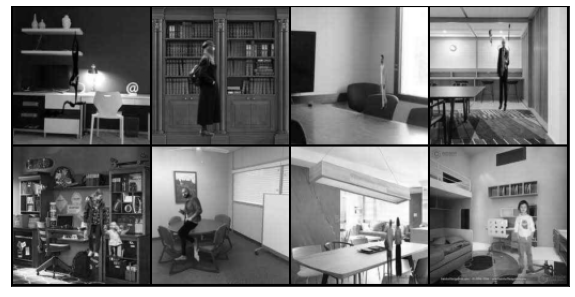

In [15]:
util.show(imgs, nrow=4)

In [0]:
dropout_value = 0.20

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        out = F.dropout(out, p=dropout_value)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNetInspired(nn.Module):

    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetInspired, self).__init__()
        self.in_planes = 64
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1, padding=1, bias=False, groups=32),
            nn.Conv2d(32, 32, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        # self.convblock5 = nn.Sequential(
        #     nn.Conv2d(128, 3, 3, stride=1, padding=1, bias=False),
        # )
        self.convblock4 = nn.Sequential(
            nn.Conv2d(128, 1, 3, stride=1, padding=1, bias=False),
        )

        self.conv1 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, 1, stride=1)
        self.layer2 = self._make_layer(block, 128, 1, stride=2)
        self.layer3 = self._make_layer(block, 256, 1, stride=2)
        self.layer4 = self._make_layer(block, 512, 1, stride=2)
        self.layer5 = self._make_layer(block, 1024, 1, stride=2)
        self.layer6 = self._make_layer(block, 512, 2, stride=1)
        self.layer7 = self._make_layer(block, 256, 1, stride=1)
        self.layer8 = self._make_layer(block, 128, 1, stride=1)
        self.layer9 = self._make_layer(block, 64, 1, stride=1)
        # self.layer10 = self._make_layer(block, 512, 1, stride=2)

        # self.upconv1 = upconv(1024, 512, 3, 2)
        # self.upconv2 = upconv(512, 256, 3, 2)
        # self.upconv3 = upconv(256, 128, 3, 2)
        # self.upconv4 = upconv(128, 64, 3, 2)
        self.concatConv1 =  nn.Sequential( nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1, bias=False),
                                          nn.BatchNorm2d(512),
                                                         nn.ReLU())
        self.concatConv2 = nn.Sequential( nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1, bias=False),
                                         nn.BatchNorm2d(256),
                                                         nn.ReLU())
        self.concatConv3 = nn.Sequential( nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                                         nn.ReLU())
        self.concatConv4 = nn.Sequential( nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
                                         nn.BatchNorm2d(128),
                                                         nn.ReLU())



    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):

        # f1 = self.convblock2(self.convblock1(x["f1"]))
        # f2 = self.convblock2(self.convblock1(x["f2"]))
        # f = f2-f1
        f2 = self.convblock2(self.convblock1(x))
        f1 = self.convblock2(self.convblock1(x))
        # f1 = x['f1']
        # f2 = x['f2']
        concat = torch.cat((f1, f2), 1)
        # print("conv shape:"+str(concat.shape))
        # 
        # out = F.relu(self.bn1(self.conv1(f)))
        out = F.relu(self.bn1(self.conv1(concat)))
        
        # print("mask shape:"+str(mask.shape))
        # out = F.relu(self.bn1(self.conv1(x)))
        # print("out shape:"+str(out.shape))
        out1  = self.layer1(out)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        out5 = self.layer5(out4)

        skip1= out1
        skip2= out2
        skip3= out3
        skip4= out4
        skip5= out5


        # # print("skip1 shape:"+str(skip1.shape))
        # # print("skip2 shape:"+str(skip2.shape))
        # # print("skip3 shape:"+str(skip3.shape))
        # # print("skip4 shape:"+str(skip4.shape))
        # # print("skip5 shape:"+str(skip5.shape))  
              
        # up1 = self.upconv1(out5)
        # print("Up1 Shape"+str(up1.shape))
        up1 = nn.functional.interpolate(out5, scale_factor=2, mode='bilinear', align_corners=True)
        up1 = self.layer6(up1)    
        concatup1 = torch.cat((up1, skip4), 1)
        concatup1 = self.concatConv1(concatup1)
        # print("Concat1 Shape"+str(concatup1.shape))
        
        # up2 = self.upconv2(concatup1)
        up2 = nn.functional.interpolate(concatup1, scale_factor=2, mode='bilinear', align_corners=True)
        up2 = self.layer7(up2)
        # print("Up2 Shape"+str(up2.shape))
        concatup2 = torch.cat((up2, skip3), 1)
        concatup2 = self.concatConv2(concatup2)
        # print("Concat2 Shape"+str(concatup2.shape))

        # up3 = self.upconv3(concatup2)
        up3 = nn.functional.interpolate(concatup2, scale_factor=2, mode='bilinear', align_corners=True)
        up3 = self.layer8(up3)
        
        # print("Up3 Shape"+str(up3.shape))
        concatup3 = torch.cat((up3, skip2), 1)
        concatup3 = self.concatConv3(concatup3)
        # print("Concat3 Shape"+str(concatup3.shape))

        # up4 = self.upconv4(concatup3)
        up4 = nn.functional.interpolate(concatup3, scale_factor=2, mode='bilinear', align_corners=True)
        up4 = self.layer9(up4)
        
        # print("Up4 Shape"+str(up4.shape))
        concatup4 = torch.cat((up4, skip1), 1)
        # print("Concat4 Shape"+str(concatup4.shape))
        concatup4 = self.concatConv4(concatup4)
        
        # out = self.convblock4(out)
        # out=up4
        out = self.convblock4(concatup4)
        mask = self.convblock4(self.convblock3(concat))
        return out,mask


In [26]:
model = ResNetInspired(BasicBlock, [1,1,1,1]).to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]             288
            Conv2d-5         [-1, 32, 128, 128]           1,024
       BatchNorm2d-6         [-1, 32, 128, 128]              64
              ReLU-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]             864
       BatchNorm2d-9         [-1, 32, 128, 128]              64
             ReLU-10         [-1, 32, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]             288
           Conv2d-12         [-1, 32, 128, 128]           1,024
      BatchNorm2d-13         [-1, 32, 128, 128]              64
             ReLU-14         [-1, 32, 1

In [0]:
def train(model, criterion, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, data in enumerate(train_loader):
        data["f1"] = data["f1"].to(device)
        data["f2"] = data["f2"].to(device)
        data["f3"] = data["f3"].to(device)
        data["f4"] = data["f4"].to(device)
        optim.zero_grad()
        output = model(data)
        # print(len(output))
        loss1 = criterion(output[0], data["f4"])
        # print((output[0].shape))
        # print((data["f4"].shape))
        # print((output[1].shape))
        # print((data["f3"].shape))
        
        loss2 = criterion(output[1], data["f3"])
        
        loss = 2*loss2+loss1
        loss.backward()
        optim.step()
        if batch_idx % 500 == 0:
            print(loss1)
            print(loss2)
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx/ len(train_loader), loss.item()))
            print('Batch ID:', batch_idx)
            # img_grid1 = tensorboardImage(output[0].detach().cpu(), nrow=2) #nrow = sqrt-bs
            # img_grid2 = tensorboardImage(output[1].detach().cpu(), nrow=2) #nrow = sqrt-bs
            # writer.add_image('Mask', img_grid1)
            # writer.add_image('Depth', img_grid2)
            util.show_pred(output[0].detach().cpu(), nrow=2) #nrow = sqrt-bs
            util.show_pred(output[1].detach().cpu(), nrow=2) #nrow = sqrt-bs
            
            # if batch_idx % 500 == 0:
            #     torch.save(model.sate_dict(), PATH/f"{batch_idx}.pth")
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6840, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.6295, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [0/40000 (0%)]	 Loss: 1.943045
Batch ID: 0


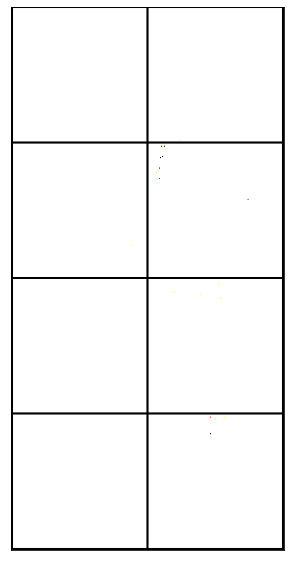

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


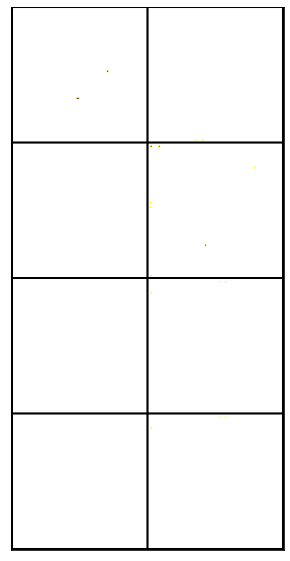

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6676, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0545, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [2000/40000 (10%)]	 Loss: 0.776485
Batch ID: 500


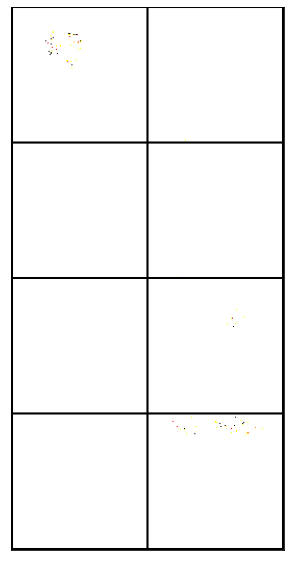

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


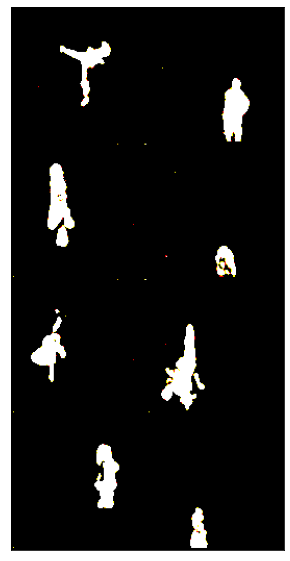

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6315, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0454, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [4000/40000 (20%)]	 Loss: 0.722362
Batch ID: 1000


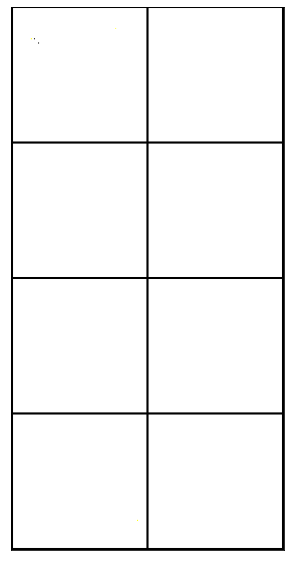

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


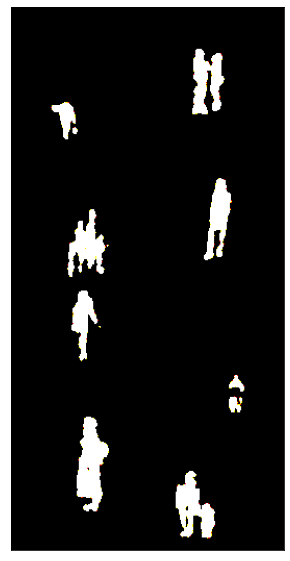

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6342, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0410, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [6000/40000 (30%)]	 Loss: 0.716298
Batch ID: 1500


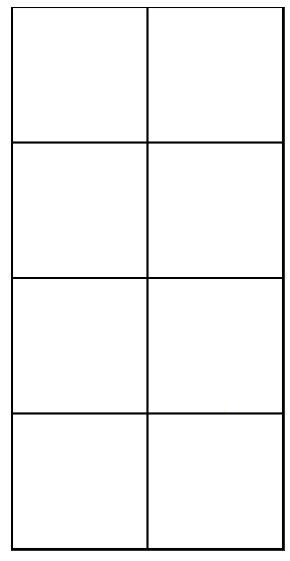

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


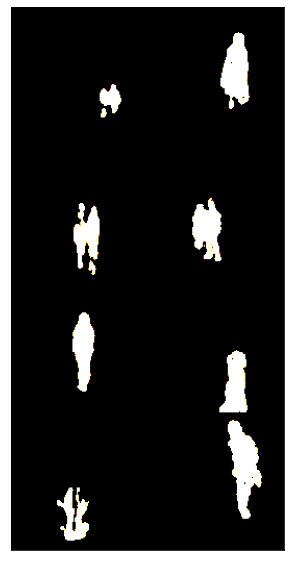

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6674, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0719, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [8000/40000 (40%)]	 Loss: 0.811148
Batch ID: 2000


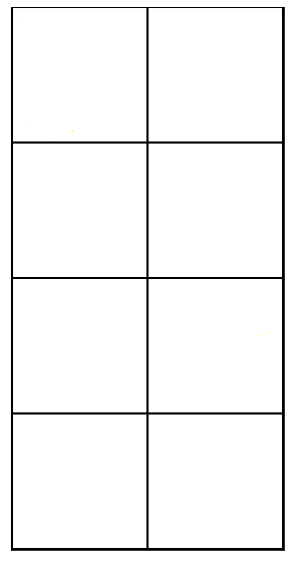

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


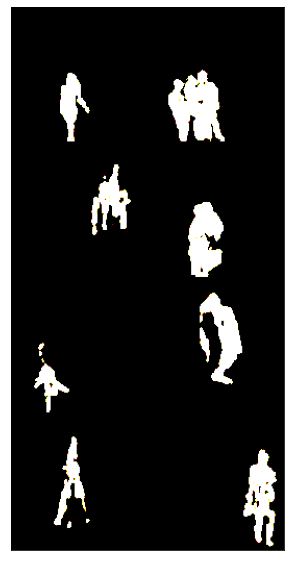

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6197, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0498, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [10000/40000 (50%)]	 Loss: 0.719343
Batch ID: 2500


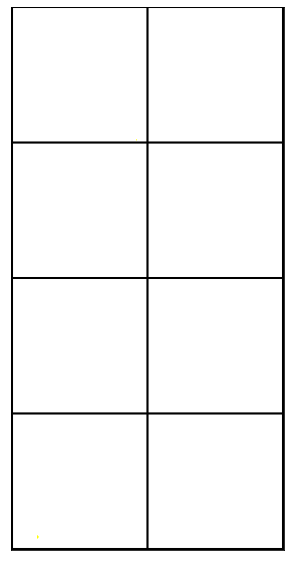

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


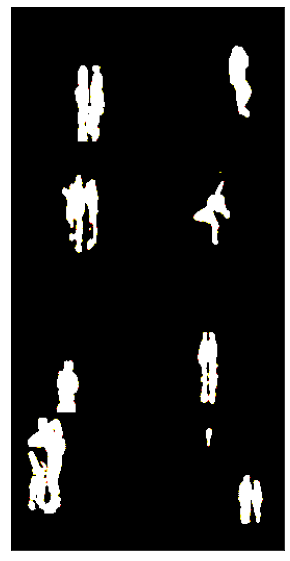

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6665, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0445, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [12000/40000 (60%)]	 Loss: 0.755551
Batch ID: 3000


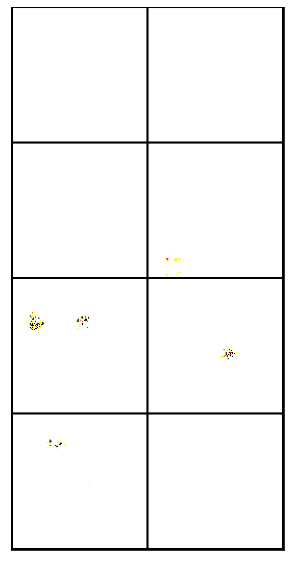

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


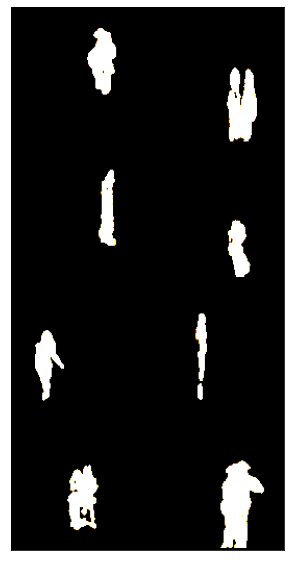

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6187, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0387, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [14000/40000 (70%)]	 Loss: 0.696027
Batch ID: 3500


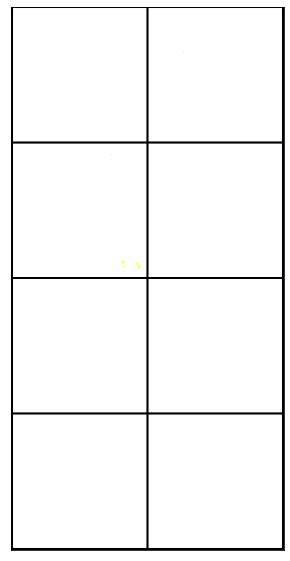

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


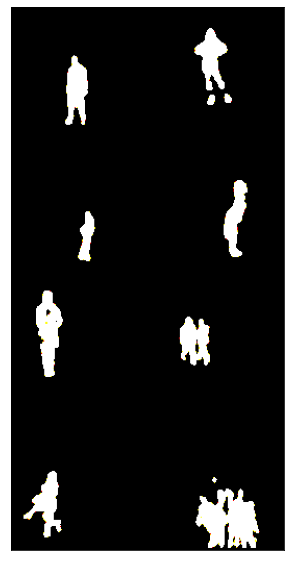

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6530, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0338, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [16000/40000 (80%)]	 Loss: 0.720540
Batch ID: 4000


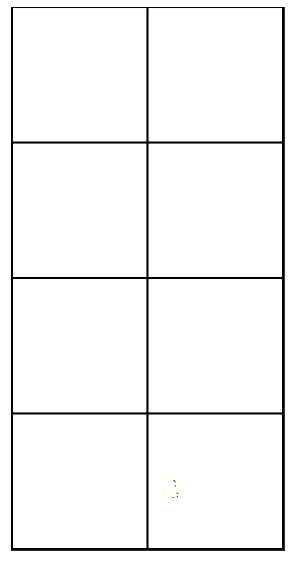

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


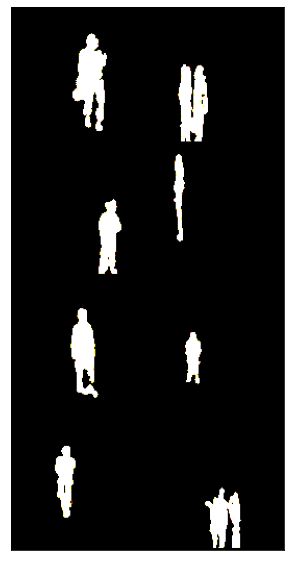

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6484, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0377, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 1 [18000/40000 (90%)]	 Loss: 0.723923
Batch ID: 4500


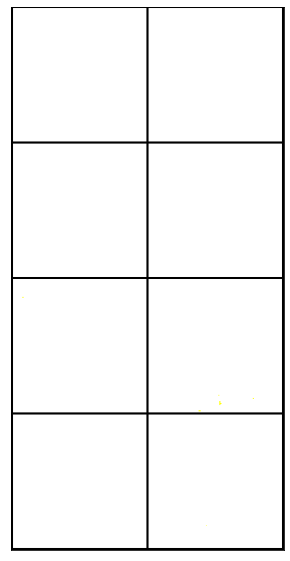

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


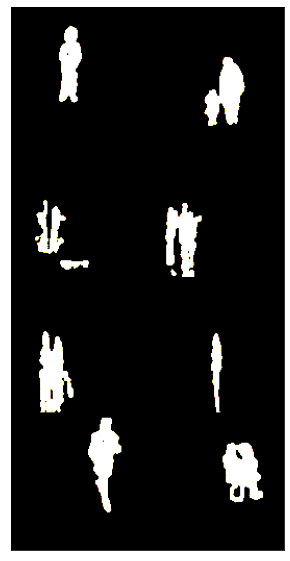

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6370, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [0/40000 (0%)]	 Loss: 0.692045
Batch ID: 0


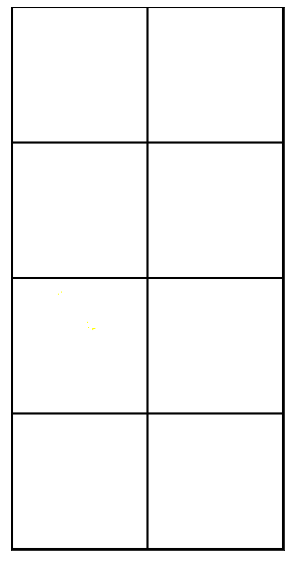

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


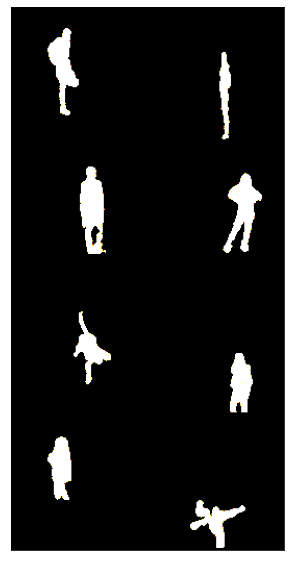

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6543, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0323, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [2000/40000 (10%)]	 Loss: 0.718919
Batch ID: 500


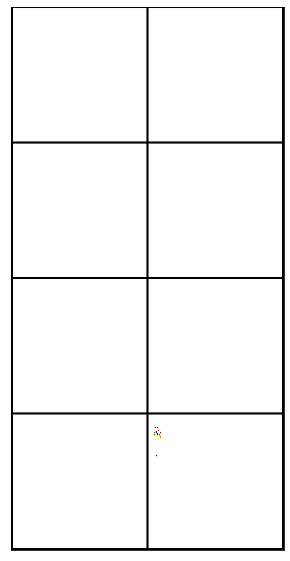

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


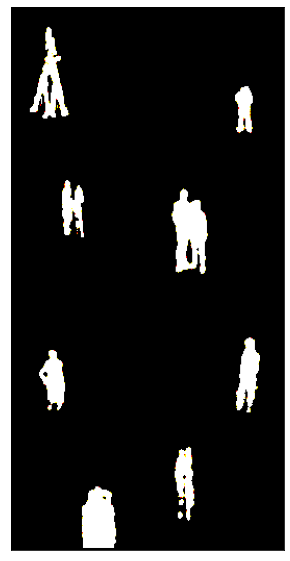

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6628, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0592, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [4000/40000 (20%)]	 Loss: 0.781235
Batch ID: 1000


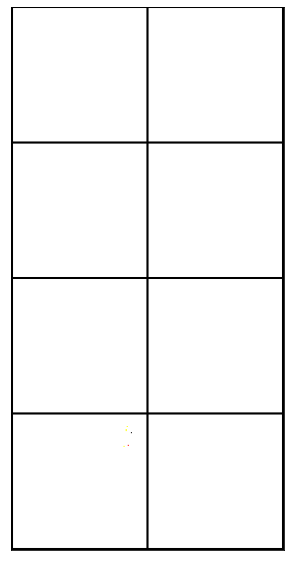

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


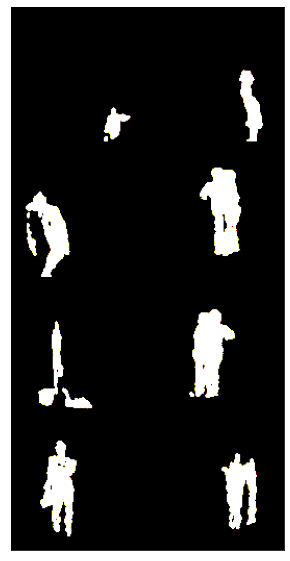

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6356, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0271, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [6000/40000 (30%)]	 Loss: 0.689785
Batch ID: 1500


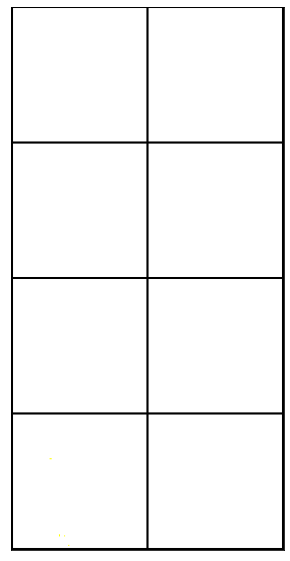

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


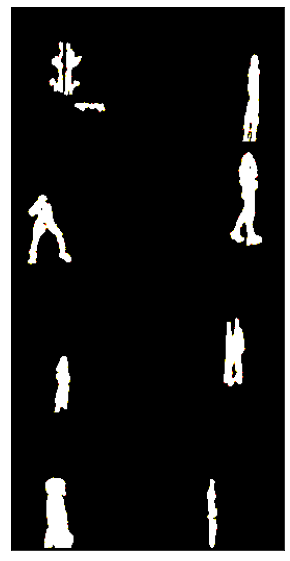

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6464, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0232, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [8000/40000 (40%)]	 Loss: 0.692743
Batch ID: 2000


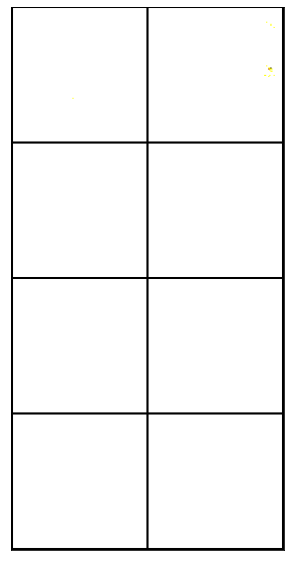

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


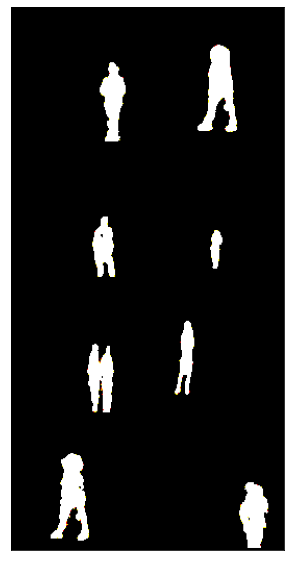

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6479, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0233, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [10000/40000 (50%)]	 Loss: 0.694489
Batch ID: 2500


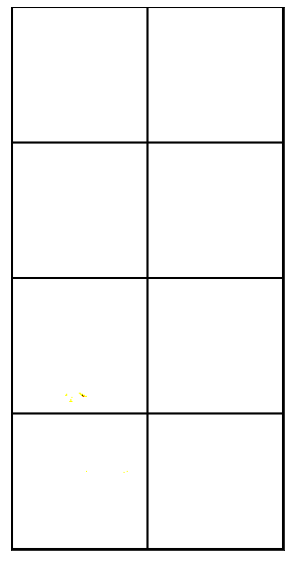

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


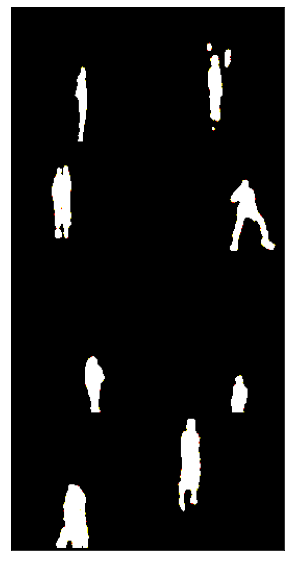

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6164, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0335, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [12000/40000 (60%)]	 Loss: 0.683362
Batch ID: 3000


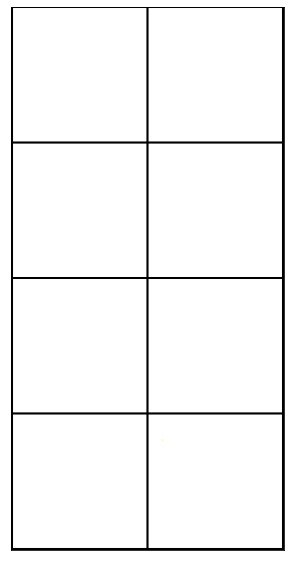

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


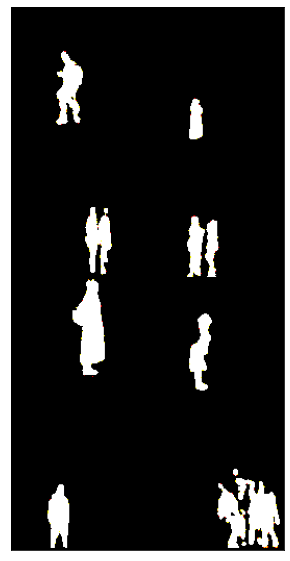

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6312, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0422, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [14000/40000 (70%)]	 Loss: 0.715659
Batch ID: 3500


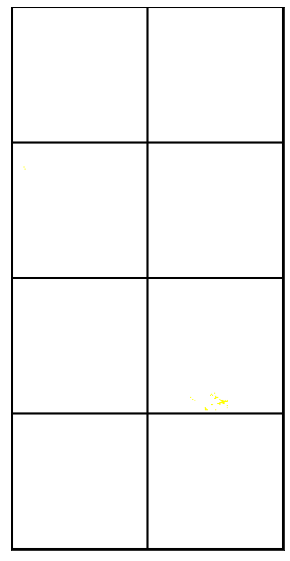

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


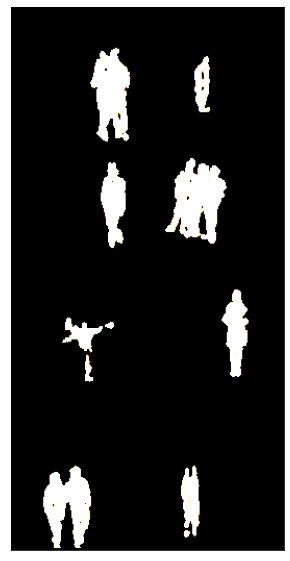

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6333, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0305, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [16000/40000 (80%)]	 Loss: 0.694173
Batch ID: 4000


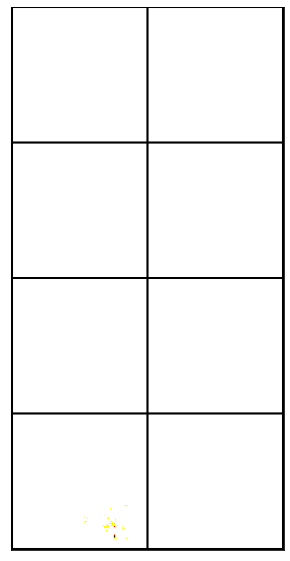

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


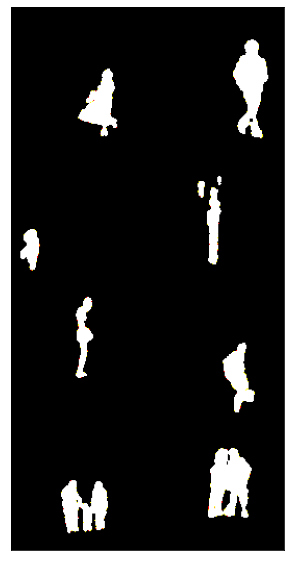

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 2 [18000/40000 (90%)]	 Loss: 0.691817
Batch ID: 4500


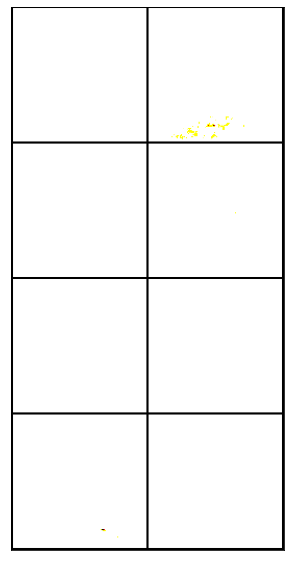

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


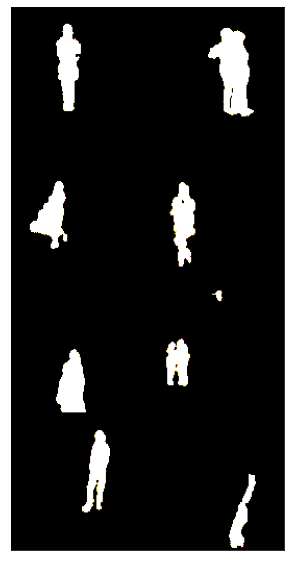

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6272, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0181, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [0/40000 (0%)]	 Loss: 0.663437
Batch ID: 0


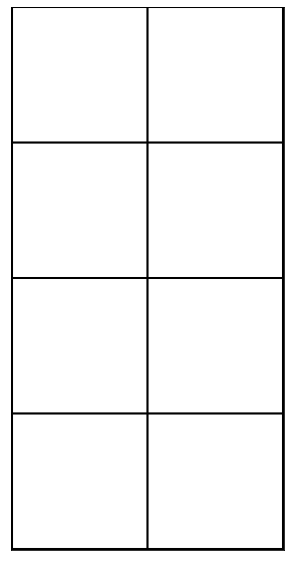

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


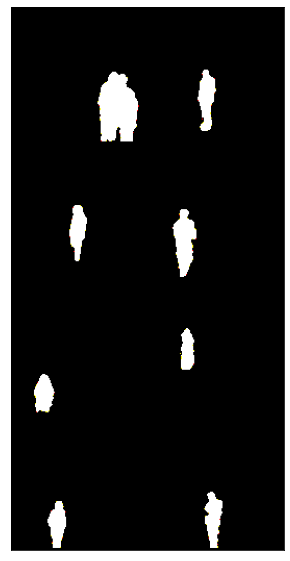

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5919, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [2000/40000 (10%)]	 Loss: 0.637385
Batch ID: 500


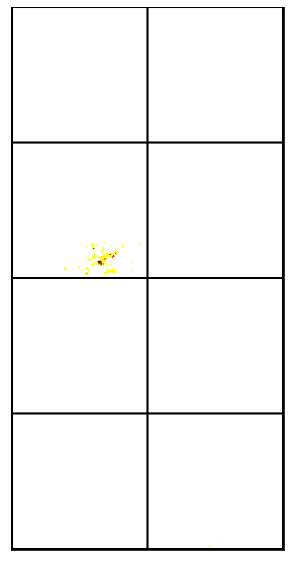

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


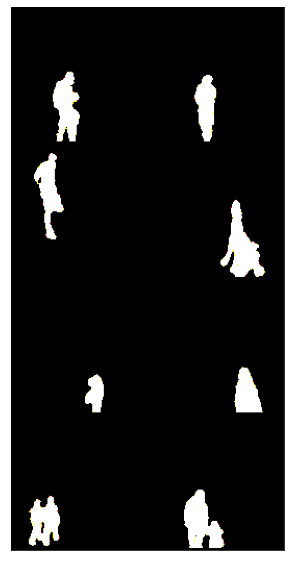

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6435, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0228, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [4000/40000 (20%)]	 Loss: 0.689089
Batch ID: 1000


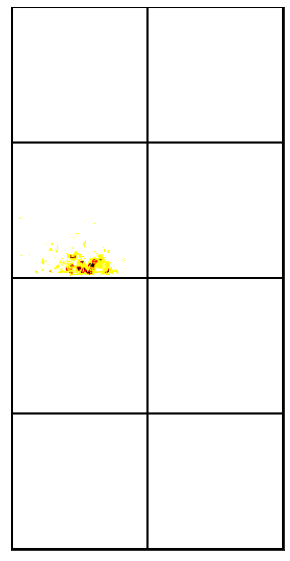

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


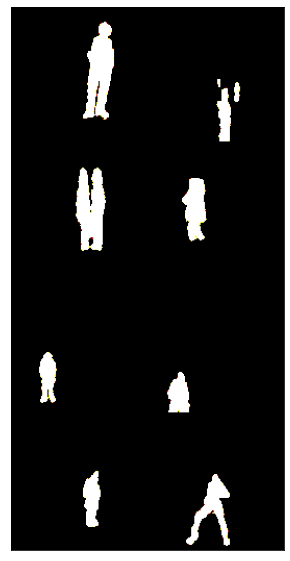

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6227, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0253, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [6000/40000 (30%)]	 Loss: 0.673267
Batch ID: 1500


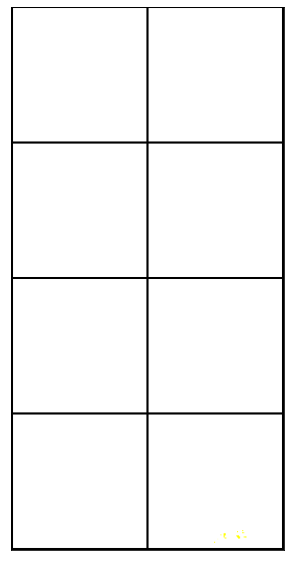

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


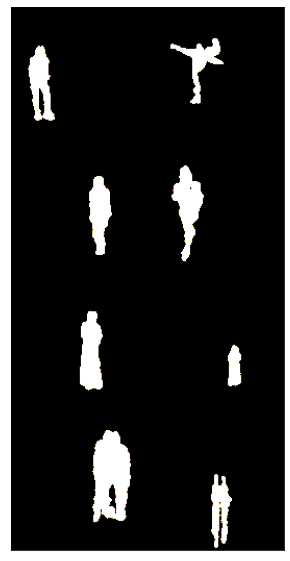

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6396, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0189, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [8000/40000 (40%)]	 Loss: 0.677442
Batch ID: 2000


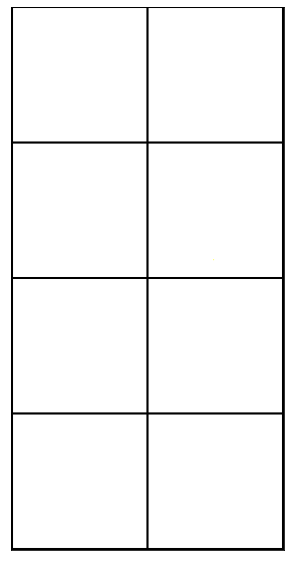

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


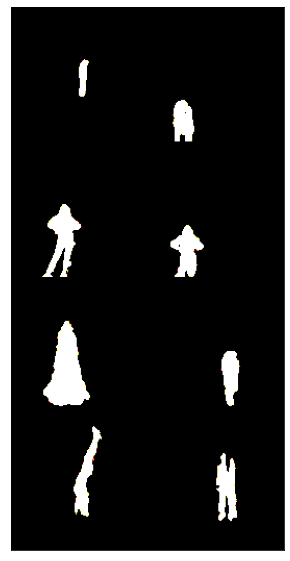

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0275, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [10000/40000 (50%)]	 Loss: 0.679151
Batch ID: 2500


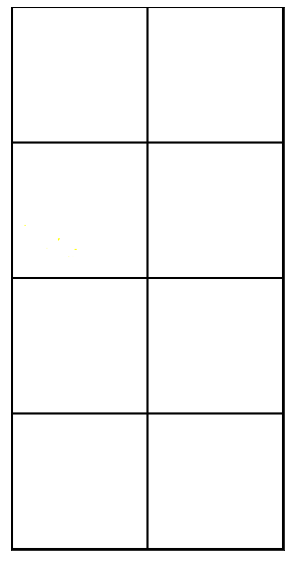

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


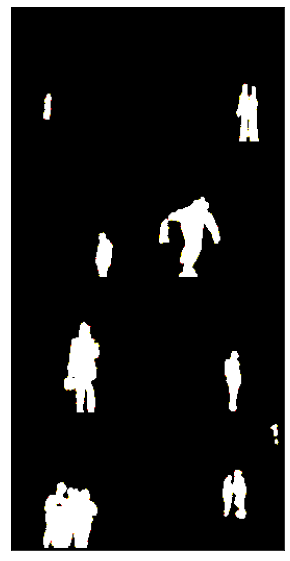

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6405, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0234, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [12000/40000 (60%)]	 Loss: 0.687435
Batch ID: 3000


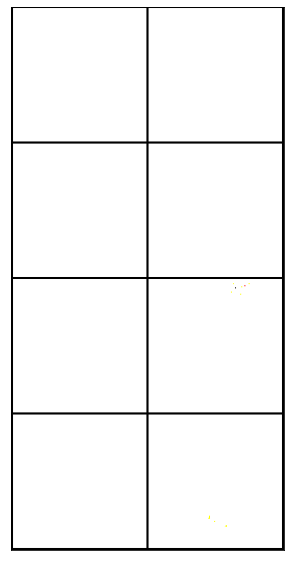

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


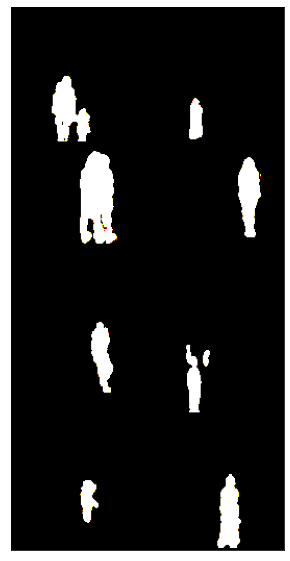

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6252, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0291, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [14000/40000 (70%)]	 Loss: 0.683443
Batch ID: 3500


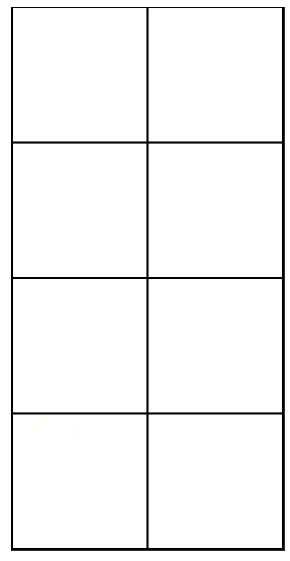

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


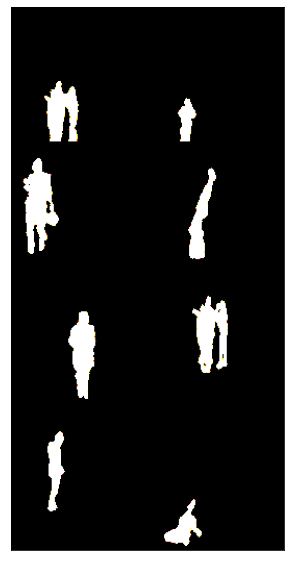

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6440, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0410, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [16000/40000 (80%)]	 Loss: 0.725893
Batch ID: 4000


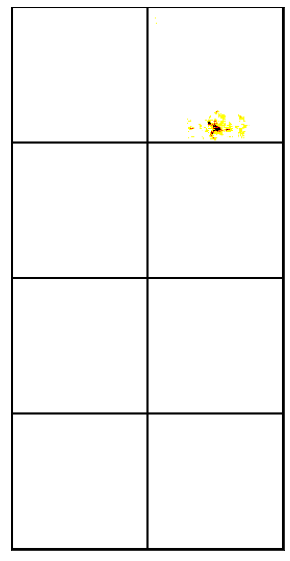

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


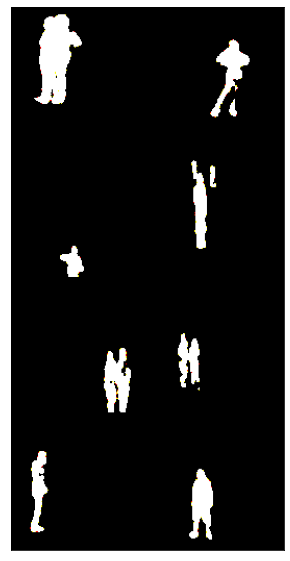

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6436, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 3 [18000/40000 (90%)]	 Loss: 0.705957
Batch ID: 4500


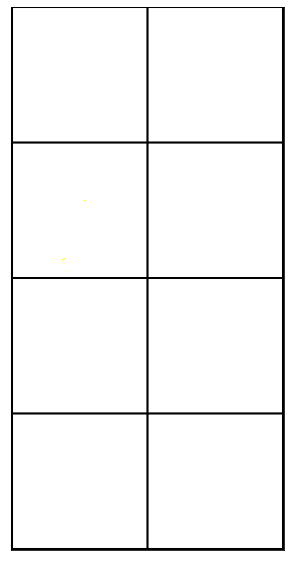

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


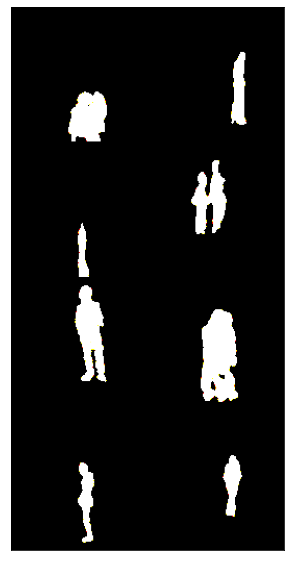

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6448, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0340, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [0/40000 (0%)]	 Loss: 0.712692
Batch ID: 0


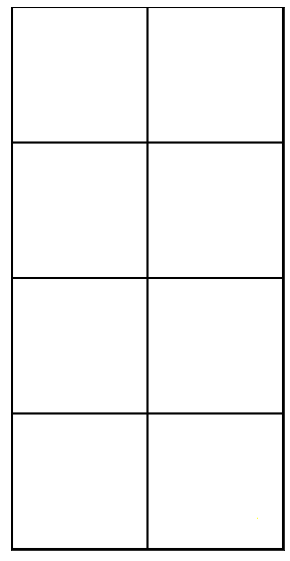

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


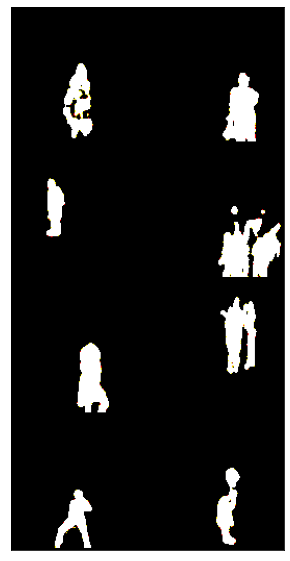

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6406, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0373, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [2000/40000 (10%)]	 Loss: 0.715104
Batch ID: 500


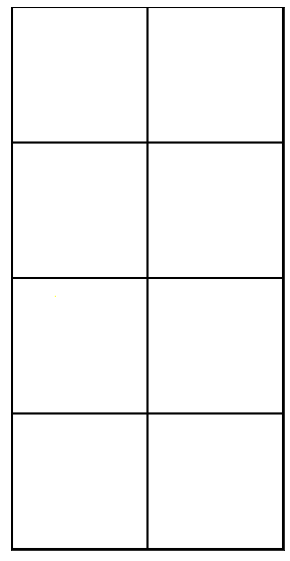

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


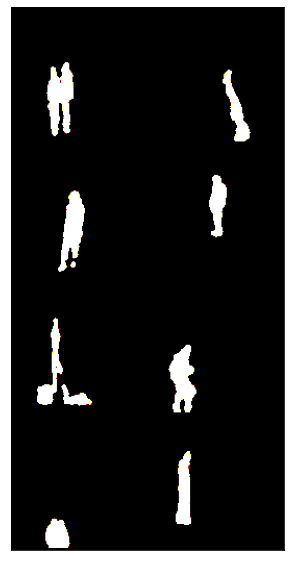

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6422, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [4000/40000 (20%)]	 Loss: 0.695799
Batch ID: 1000


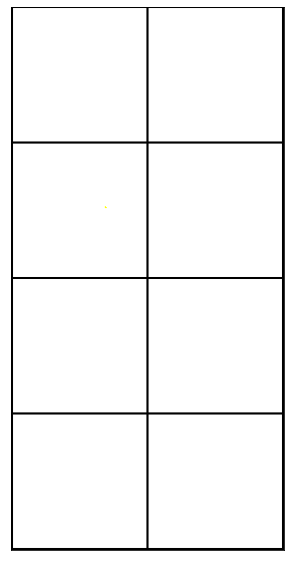

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


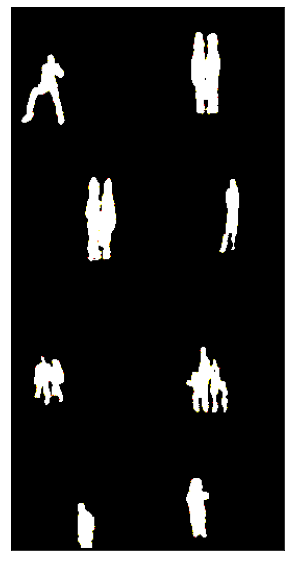

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6345, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0333, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [6000/40000 (30%)]	 Loss: 0.701134
Batch ID: 1500


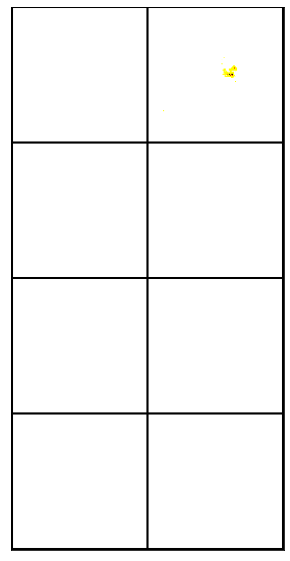

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


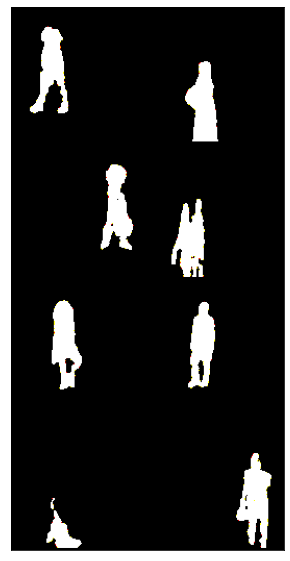

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6279, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0301, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [8000/40000 (40%)]	 Loss: 0.688122
Batch ID: 2000


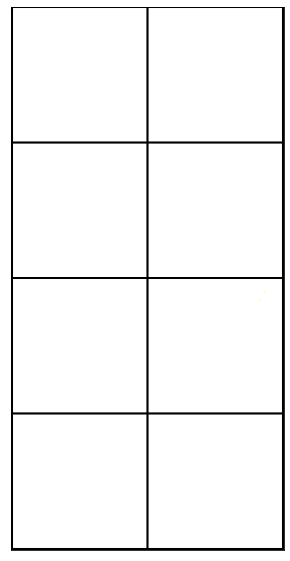

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


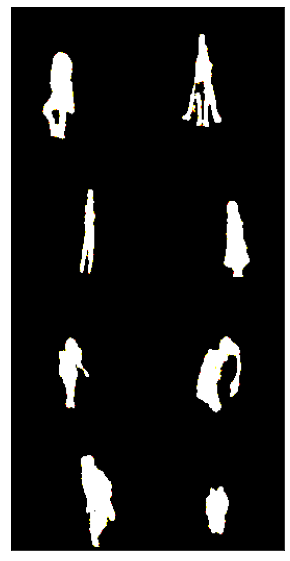

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6071, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0244, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [10000/40000 (50%)]	 Loss: 0.655917
Batch ID: 2500


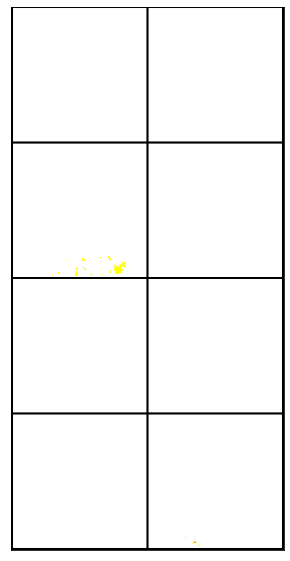

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


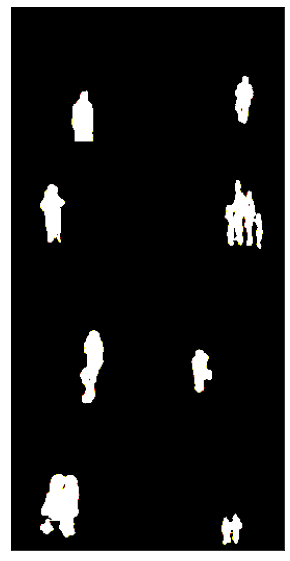

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6420, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [12000/40000 (60%)]	 Loss: 0.704415
Batch ID: 3000


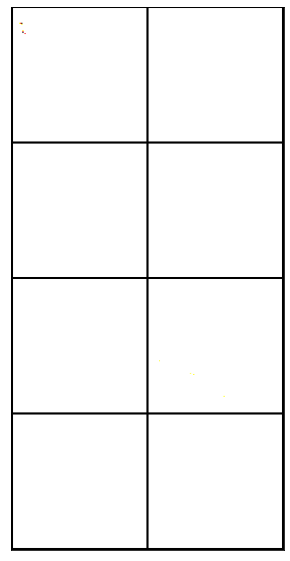

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


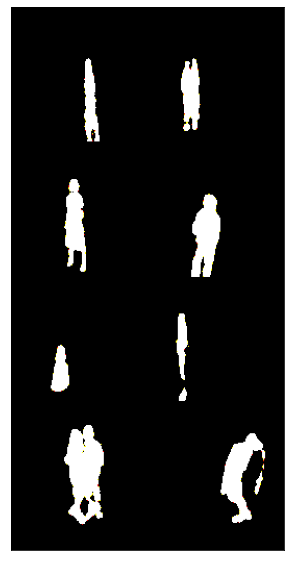

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6242, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [14000/40000 (70%)]	 Loss: 0.673776
Batch ID: 3500


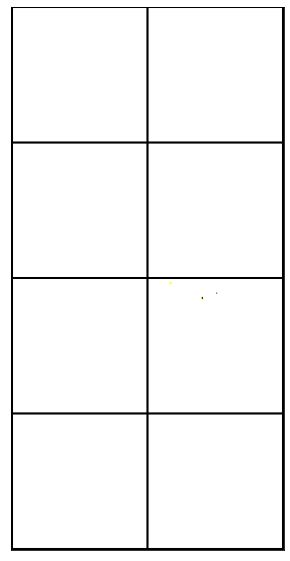

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


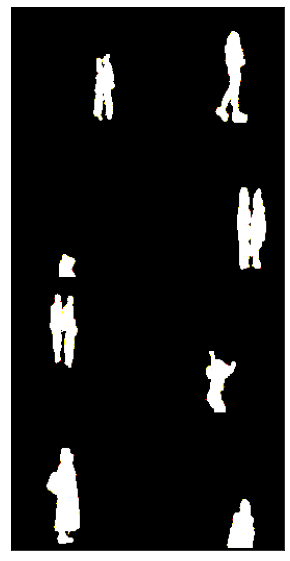

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6404, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0308, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [16000/40000 (80%)]	 Loss: 0.701983
Batch ID: 4000


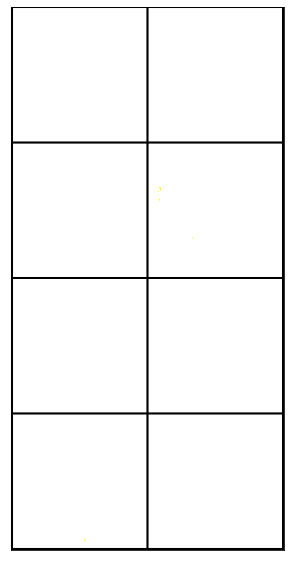

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


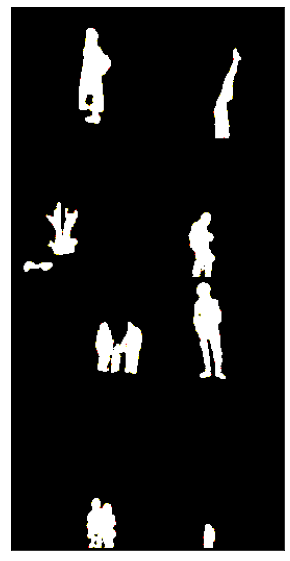

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6271, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0248, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 4 [18000/40000 (90%)]	 Loss: 0.676815
Batch ID: 4500


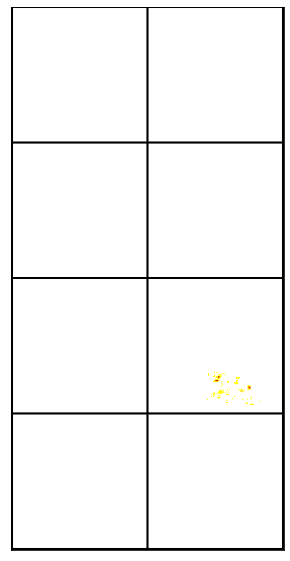

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


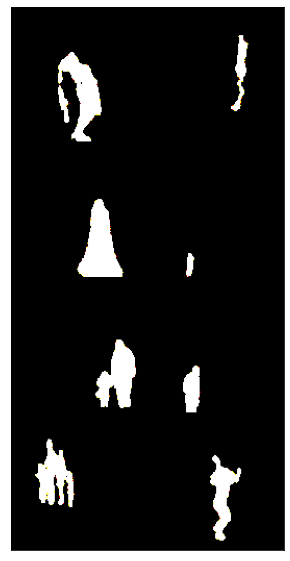

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6254, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0249, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [0/40000 (0%)]	 Loss: 0.675106
Batch ID: 0


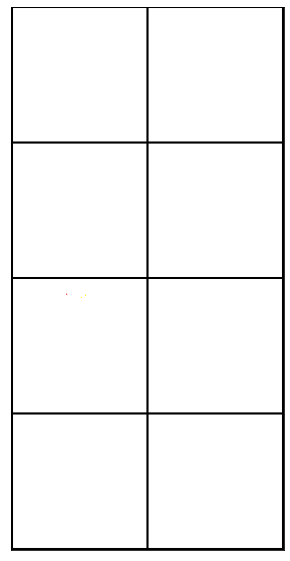

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


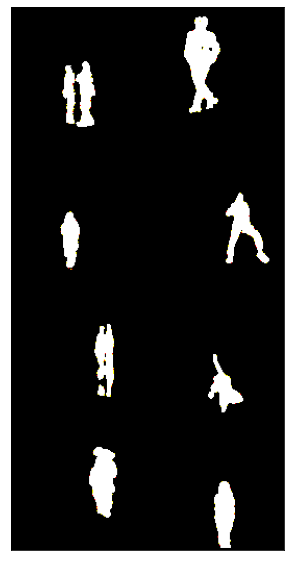

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6493, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0529, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [2000/40000 (10%)]	 Loss: 0.755140
Batch ID: 500


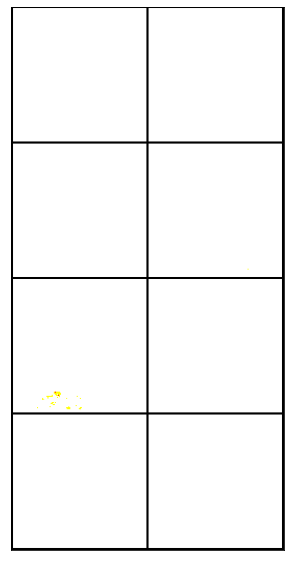

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


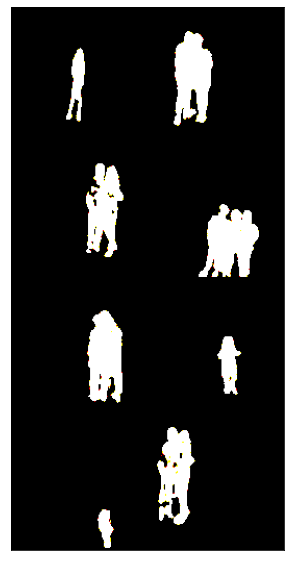

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6603, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0212, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [4000/40000 (20%)]	 Loss: 0.702708
Batch ID: 1000


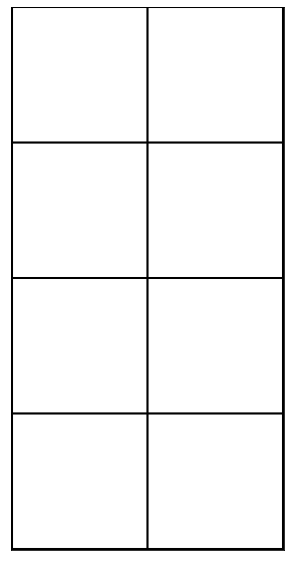

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


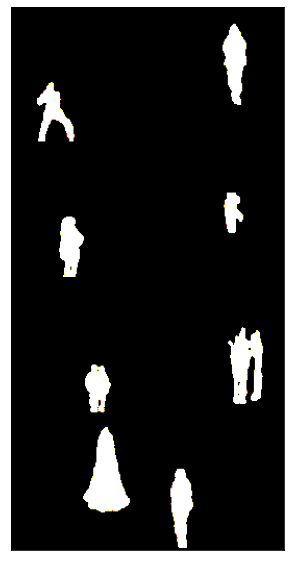

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6431, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0217, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [6000/40000 (30%)]	 Loss: 0.686481
Batch ID: 1500


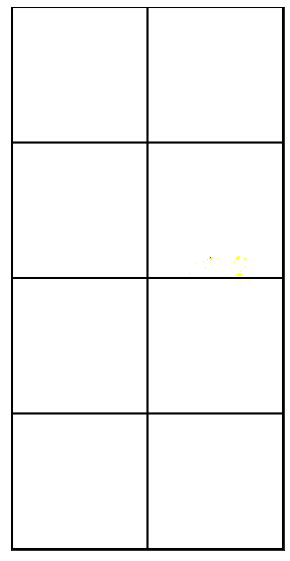

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


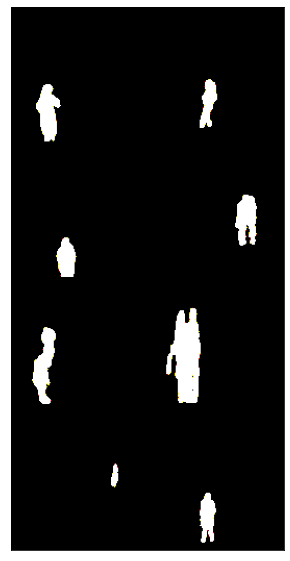

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6219, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0374, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [8000/40000 (40%)]	 Loss: 0.696612
Batch ID: 2000


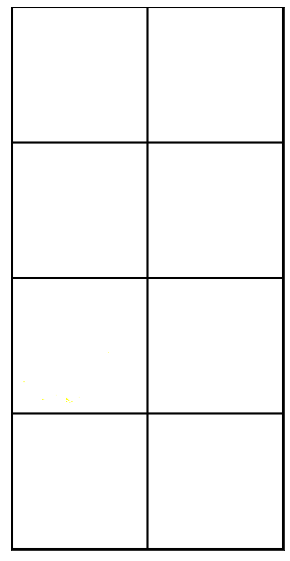

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


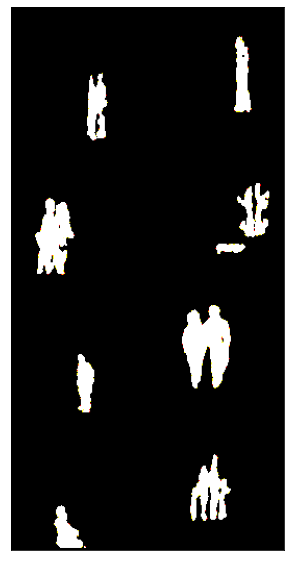

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6427, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0294, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [10000/40000 (50%)]	 Loss: 0.701490
Batch ID: 2500


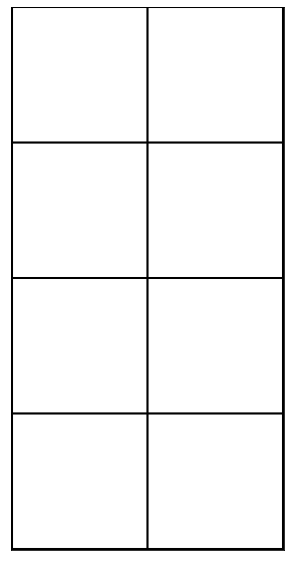

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


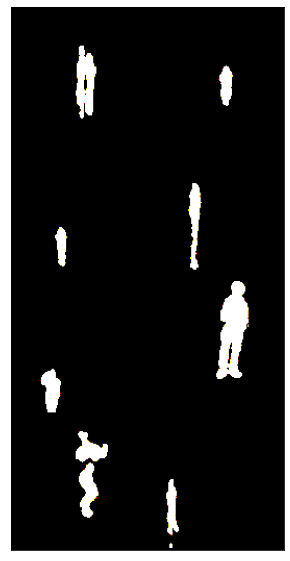

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6299, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0244, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [12000/40000 (60%)]	 Loss: 0.678569
Batch ID: 3000


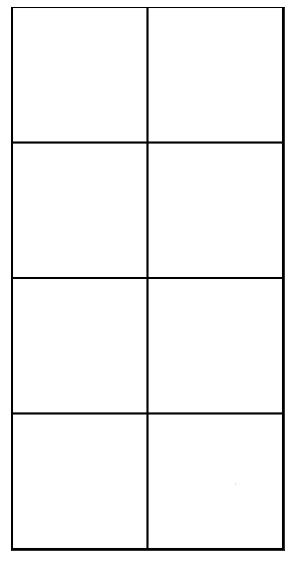

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


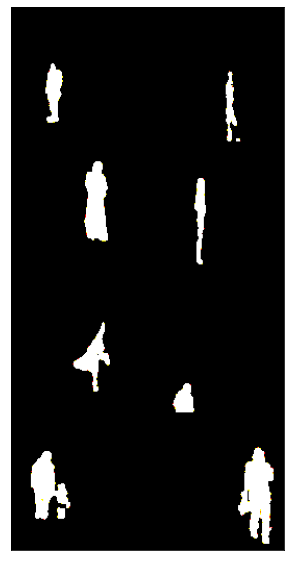

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6698, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0266, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [14000/40000 (70%)]	 Loss: 0.722952
Batch ID: 3500


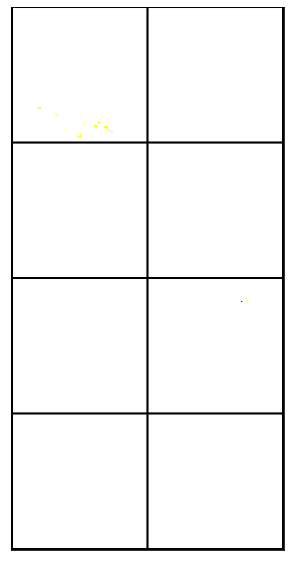

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


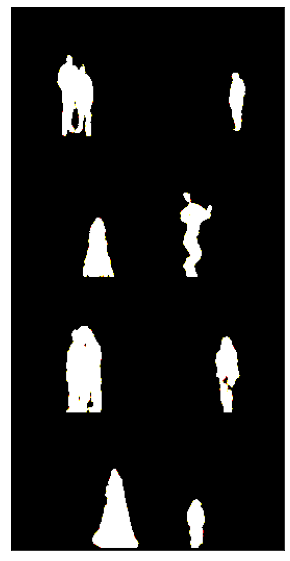

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6365, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0387, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [16000/40000 (80%)]	 Loss: 0.713966
Batch ID: 4000


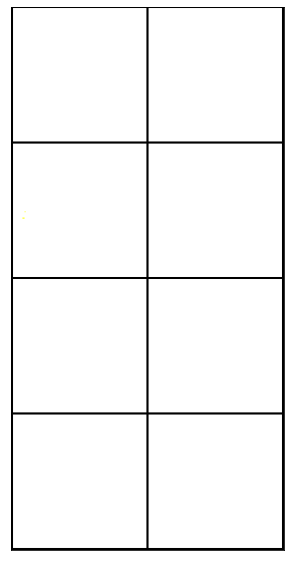

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


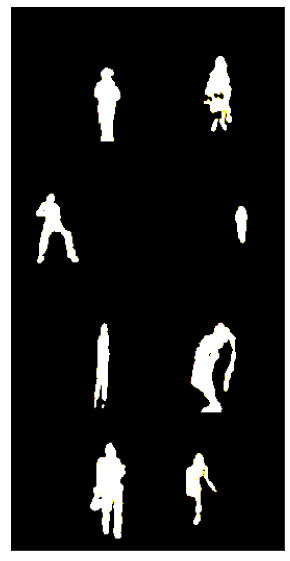

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6540, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0266, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 5 [18000/40000 (90%)]	 Loss: 0.707231
Batch ID: 4500


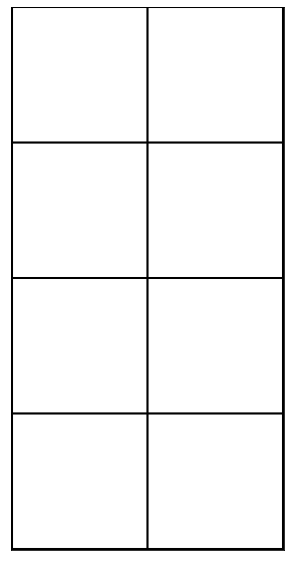

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


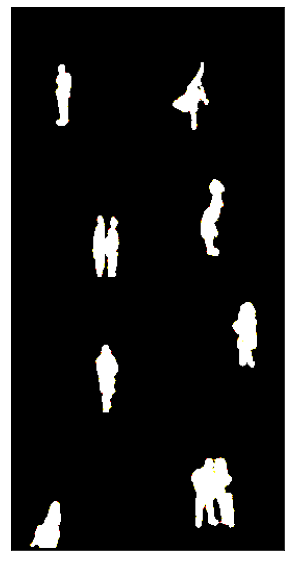

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6331, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0241, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [0/40000 (0%)]	 Loss: 0.681251
Batch ID: 0


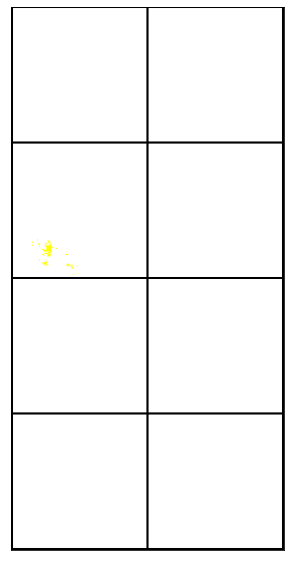

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


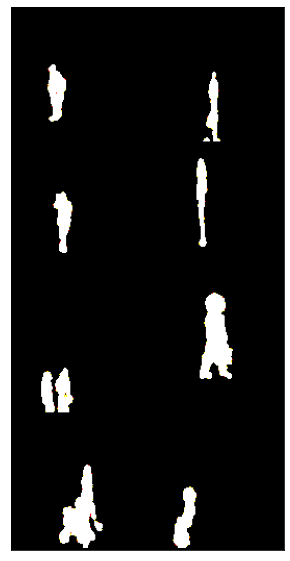

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6419, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0482, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [2000/40000 (10%)]	 Loss: 0.738286
Batch ID: 500


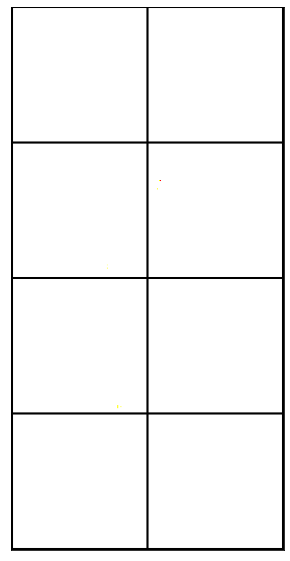

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


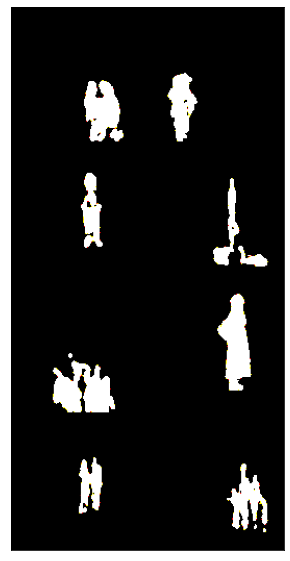

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6133, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0324, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [4000/40000 (20%)]	 Loss: 0.678095
Batch ID: 1000


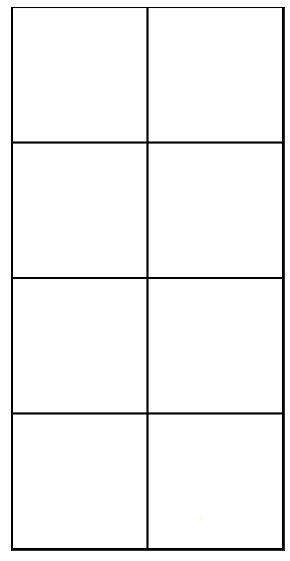

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


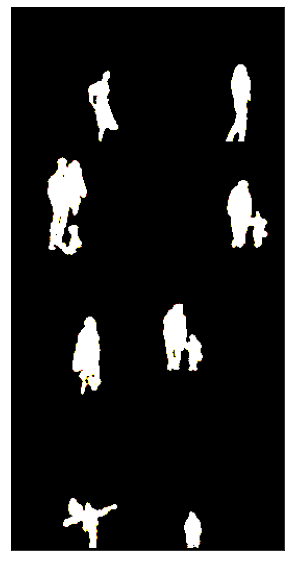

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6476, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0463, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [6000/40000 (30%)]	 Loss: 0.740106
Batch ID: 1500


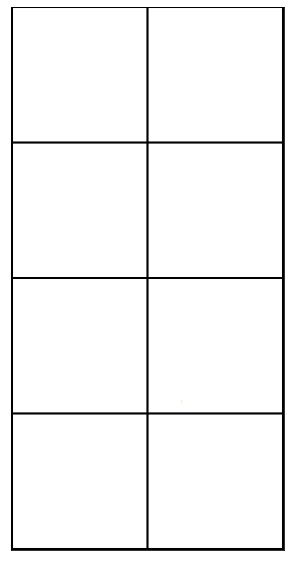

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


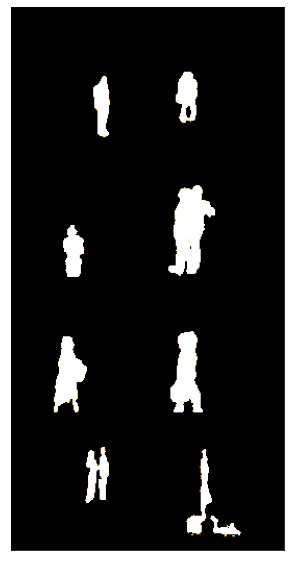

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6428, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0272, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [8000/40000 (40%)]	 Loss: 0.697204
Batch ID: 2000


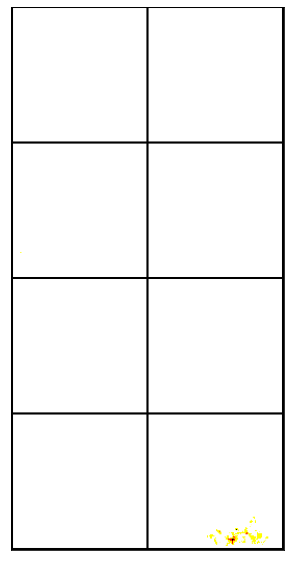

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


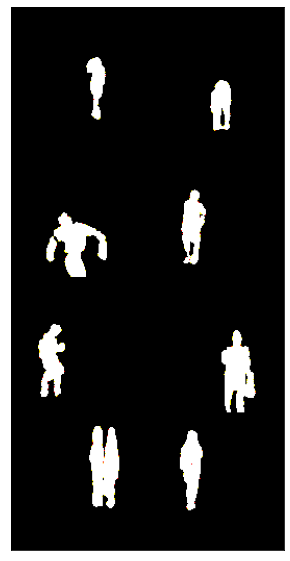

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6306, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [10000/40000 (50%)]	 Loss: 0.679848
Batch ID: 2500


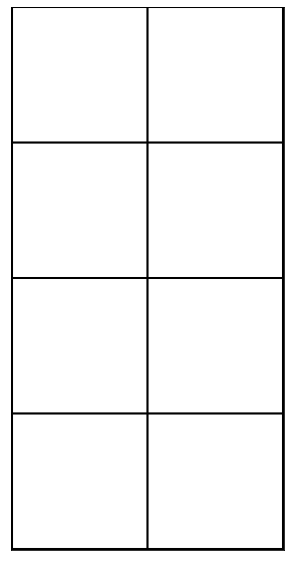

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


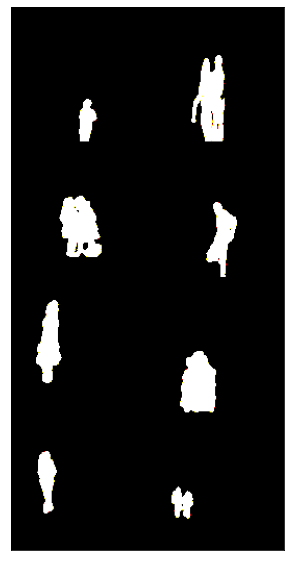

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6160, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [12000/40000 (60%)]	 Loss: 0.657093
Batch ID: 3000


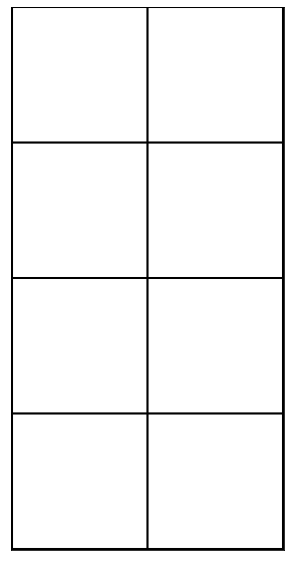

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


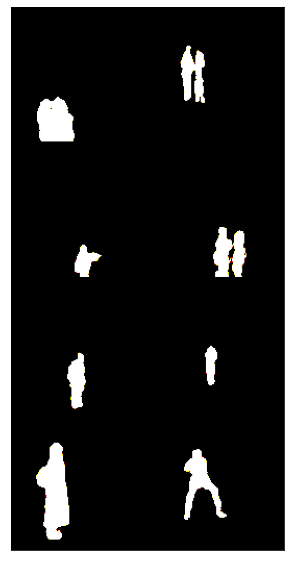

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6103, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0343, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [14000/40000 (70%)]	 Loss: 0.678863
Batch ID: 3500


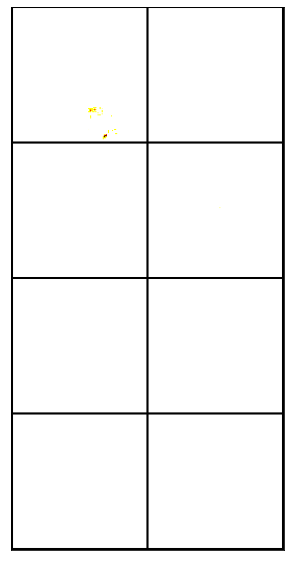

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


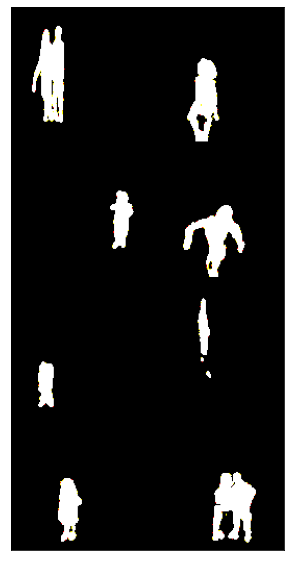

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6333, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [16000/40000 (80%)]	 Loss: 0.683605
Batch ID: 4000


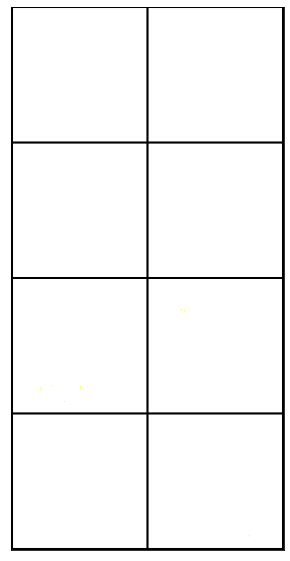

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


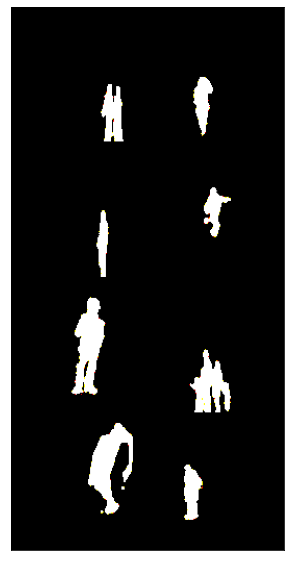

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6462, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0262, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 6 [18000/40000 (90%)]	 Loss: 0.698590
Batch ID: 4500


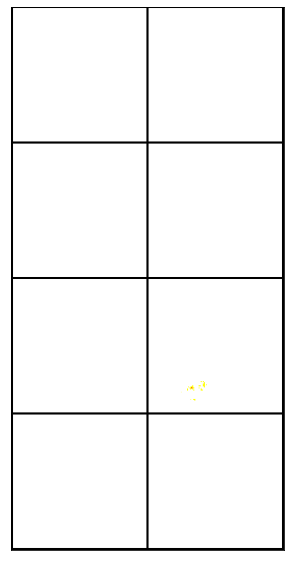

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


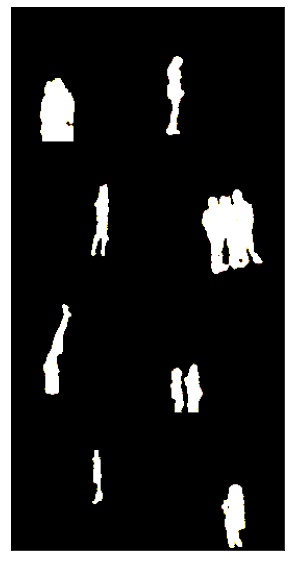

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6586, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0348, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [0/40000 (0%)]	 Loss: 0.728259
Batch ID: 0


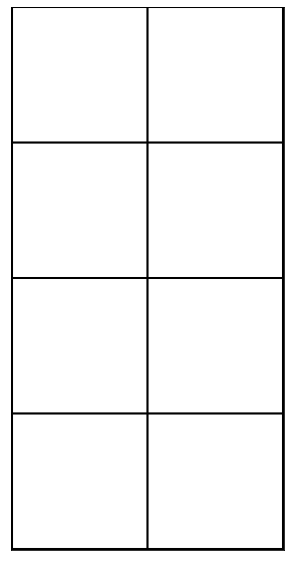

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


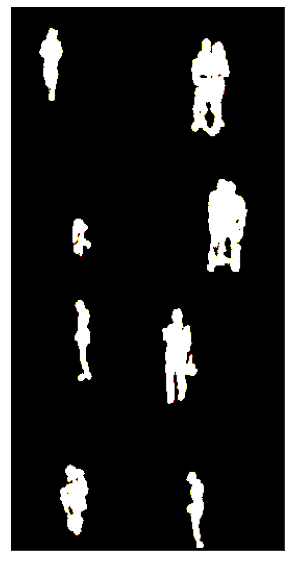

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6609, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0291, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [2000/40000 (10%)]	 Loss: 0.719101
Batch ID: 500


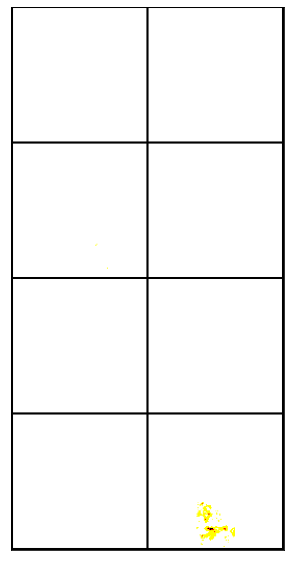

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


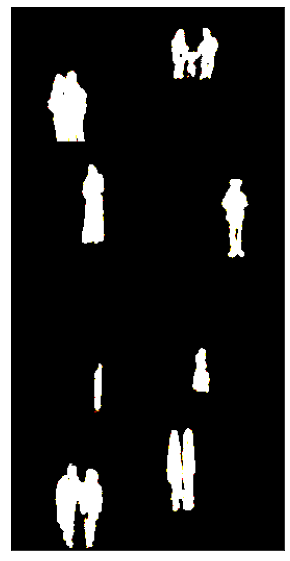

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6636, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0224, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [4000/40000 (20%)]	 Loss: 0.708309
Batch ID: 1000


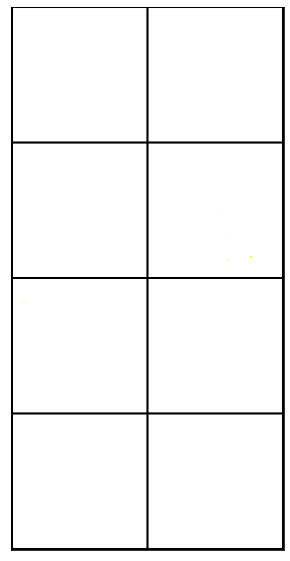

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


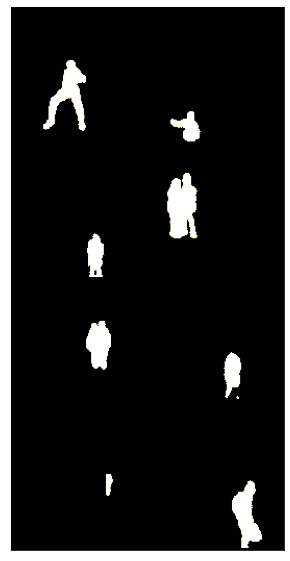

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6586, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0320, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [6000/40000 (30%)]	 Loss: 0.722665
Batch ID: 1500


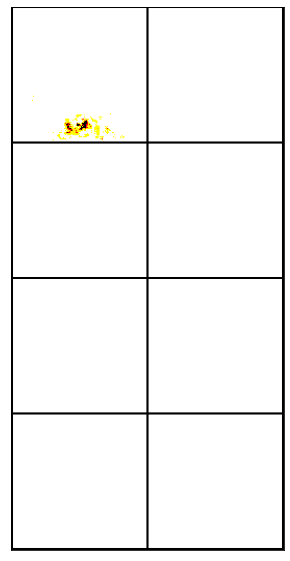

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


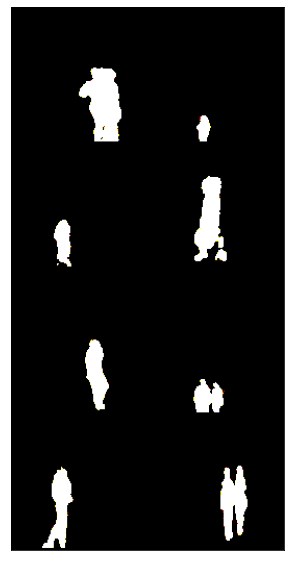

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6746, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0281, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [8000/40000 (40%)]	 Loss: 0.730831
Batch ID: 2000


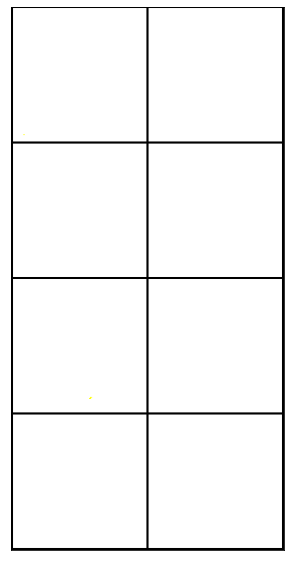

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


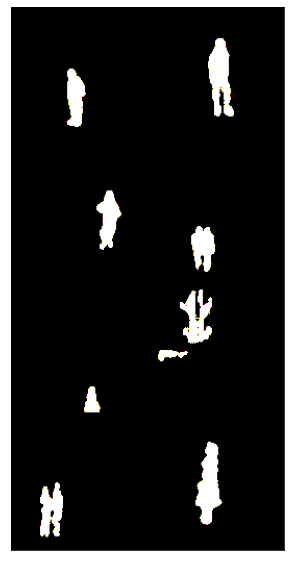

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.5896, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0293, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [10000/40000 (50%)]	 Loss: 0.648232
Batch ID: 2500


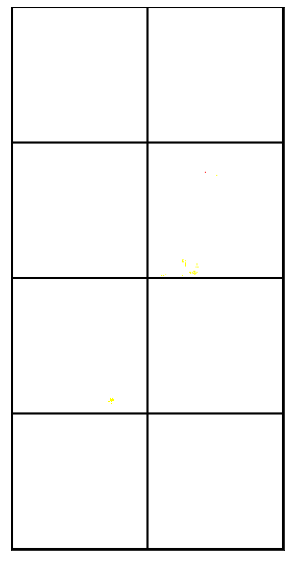

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


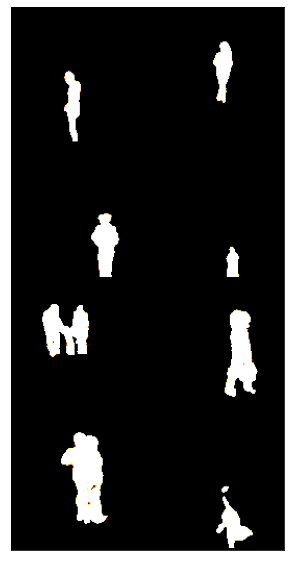

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0235, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [12000/40000 (60%)]	 Loss: 0.673856
Batch ID: 3000


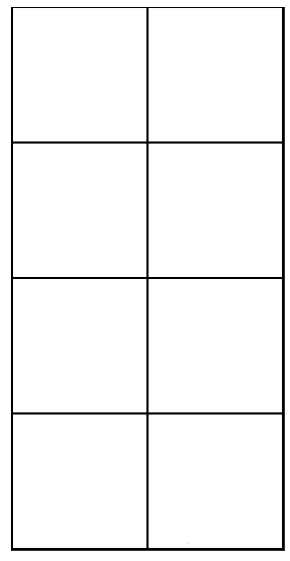

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


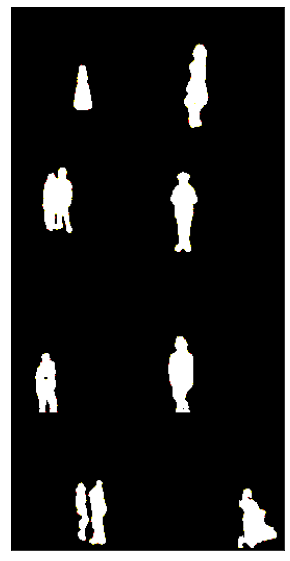

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6355, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0264, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [14000/40000 (70%)]	 Loss: 0.688223
Batch ID: 3500


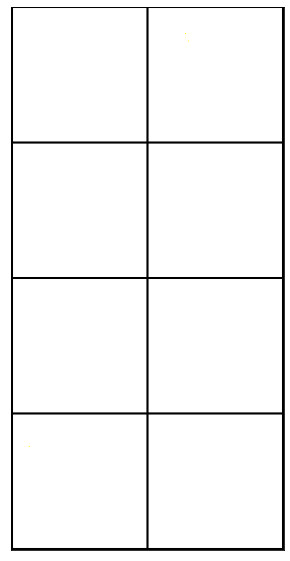

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


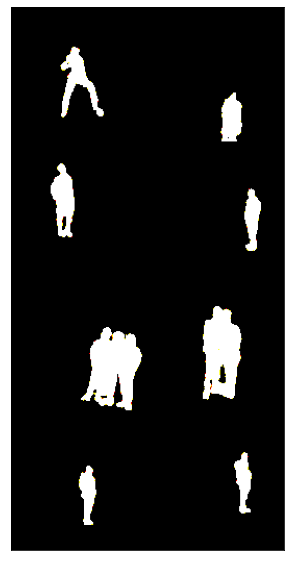

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6452, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0270, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [16000/40000 (80%)]	 Loss: 0.699178
Batch ID: 4000


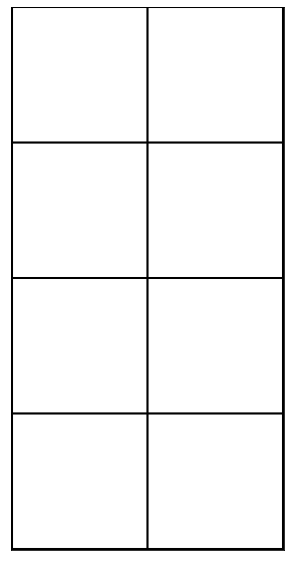

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


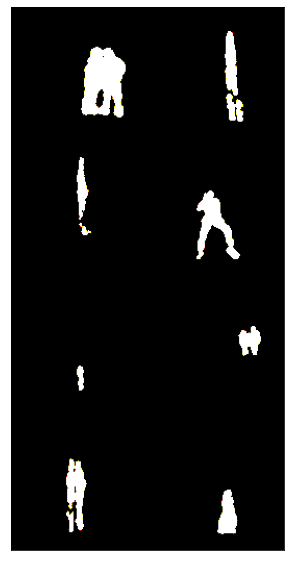

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6353, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0177, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 7 [18000/40000 (90%)]	 Loss: 0.670790
Batch ID: 4500


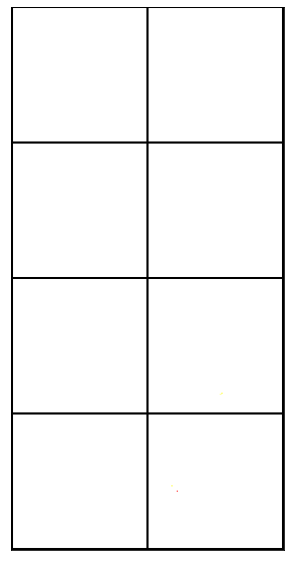

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


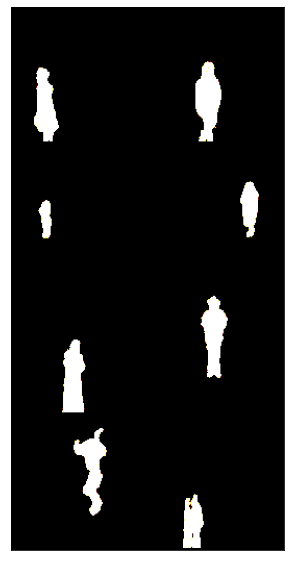

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6466, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0211, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [0/40000 (0%)]	 Loss: 0.688769
Batch ID: 0


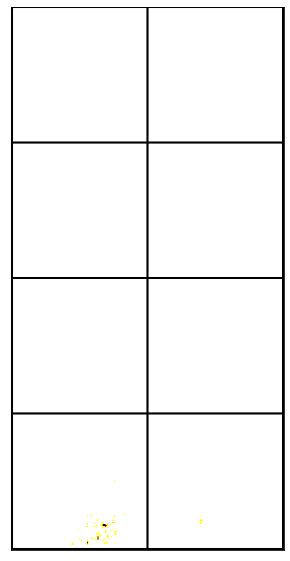

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


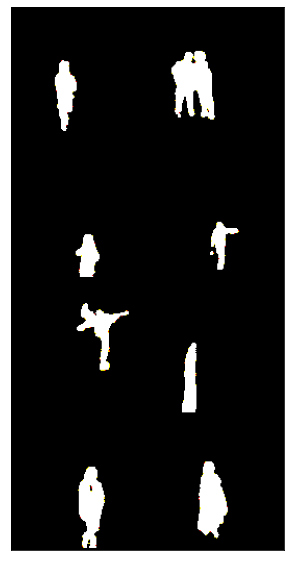

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6551, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0202, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [2000/40000 (10%)]	 Loss: 0.695500
Batch ID: 500


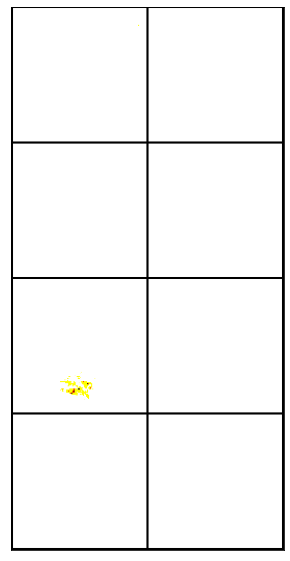

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


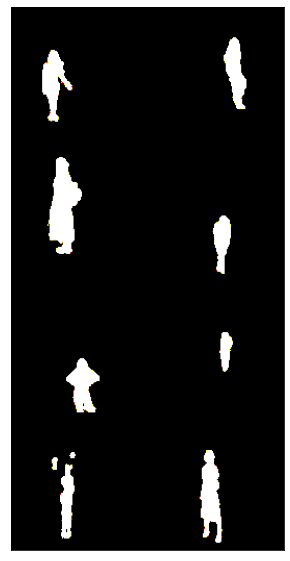

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6586, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0360, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [4000/40000 (20%)]	 Loss: 0.730612
Batch ID: 1000


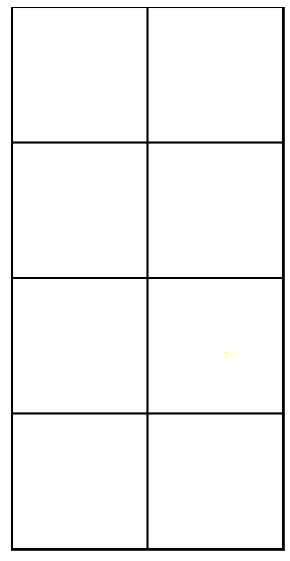

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


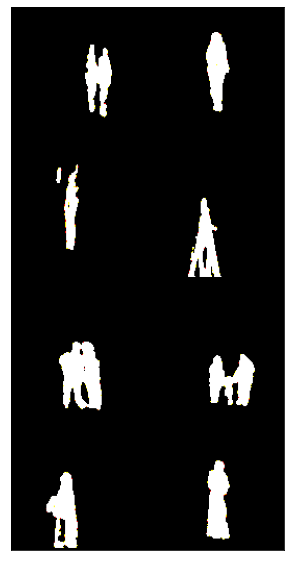

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6498, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0277, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [6000/40000 (30%)]	 Loss: 0.705053
Batch ID: 1500


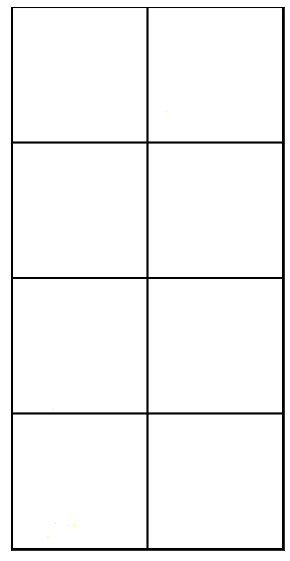

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


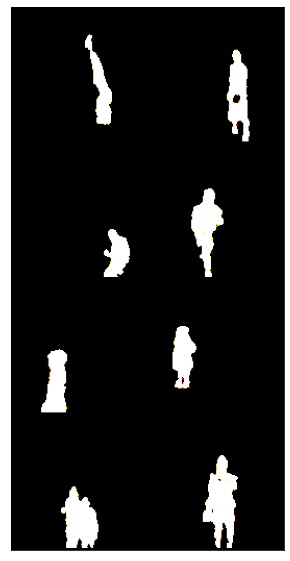

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6212, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0271, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [8000/40000 (40%)]	 Loss: 0.675389
Batch ID: 2000


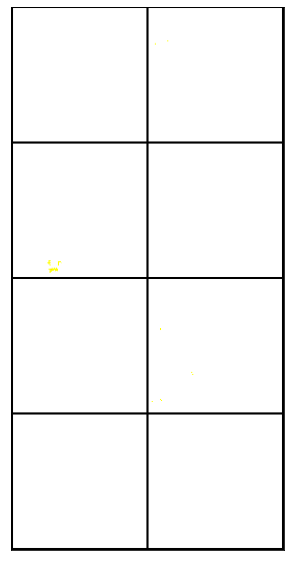

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


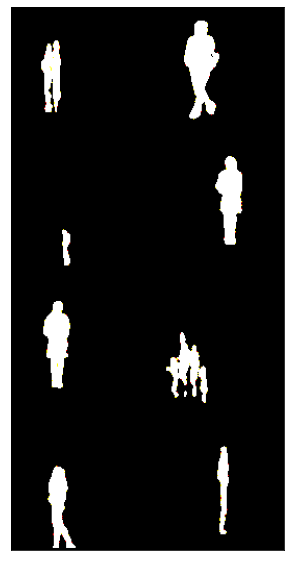

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6432, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0296, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [10000/40000 (50%)]	 Loss: 0.702441
Batch ID: 2500


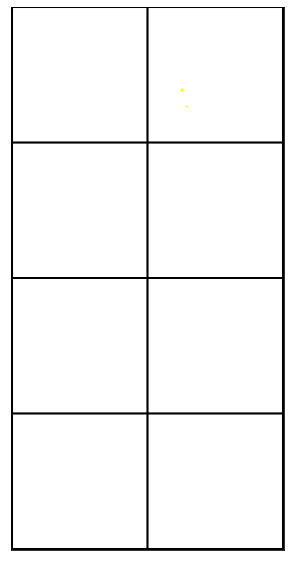

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


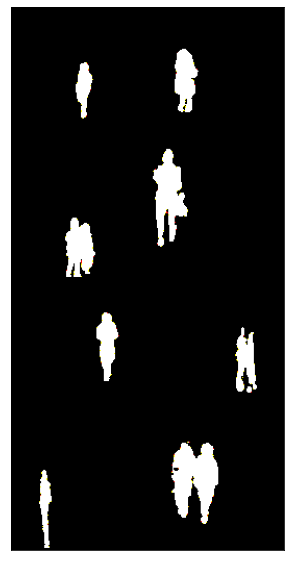

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6464, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0240, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [12000/40000 (60%)]	 Loss: 0.694441
Batch ID: 3000


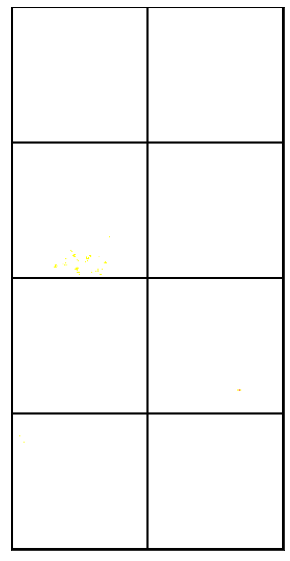

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


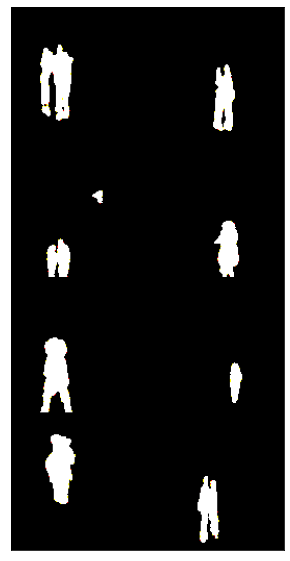

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6199, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0300, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [14000/40000 (70%)]	 Loss: 0.679956
Batch ID: 3500


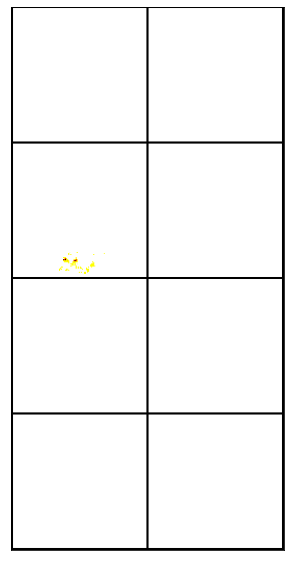

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


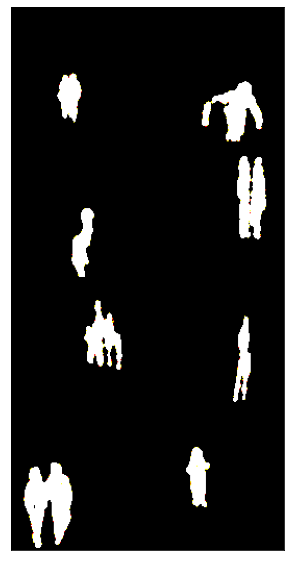

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6560, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0403, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [16000/40000 (80%)]	 Loss: 0.736476
Batch ID: 4000


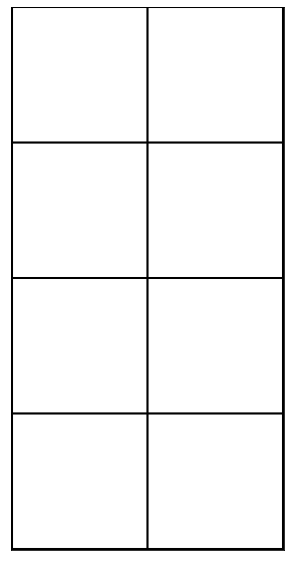

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


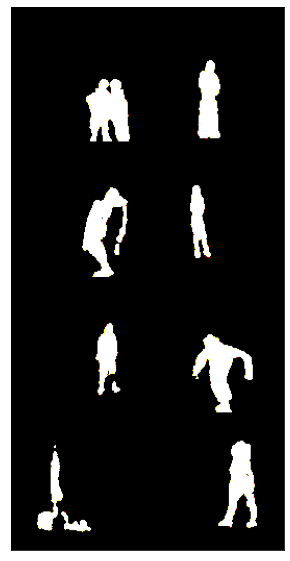

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6514, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0267, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 8 [18000/40000 (90%)]	 Loss: 0.704766
Batch ID: 4500


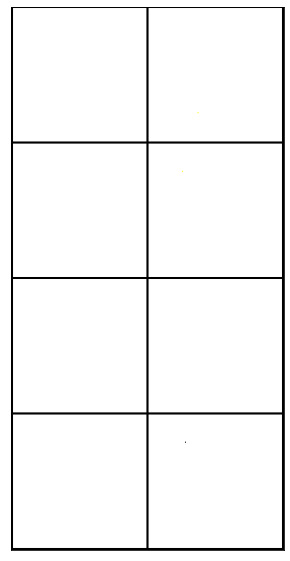

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


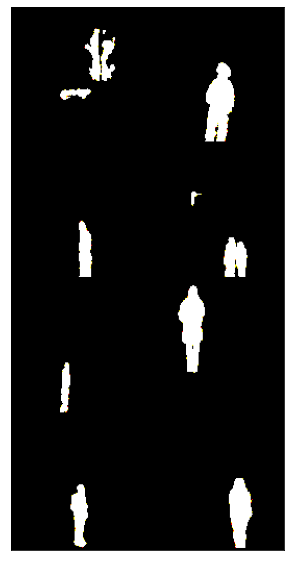

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6606, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0433, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [0/40000 (0%)]	 Loss: 0.747203
Batch ID: 0


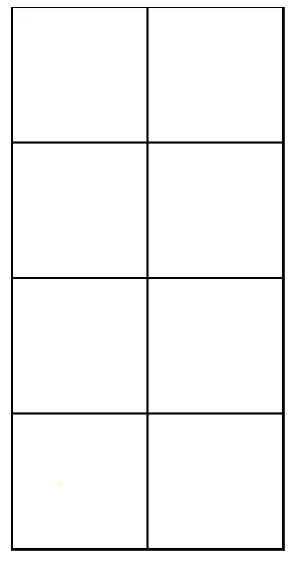

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


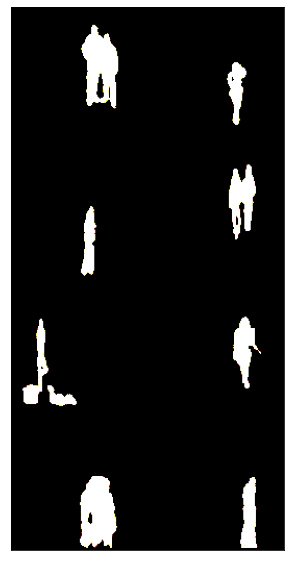

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6523, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0246, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [2000/40000 (10%)]	 Loss: 0.701355
Batch ID: 500


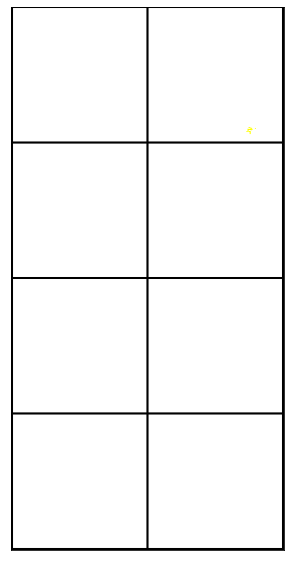

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


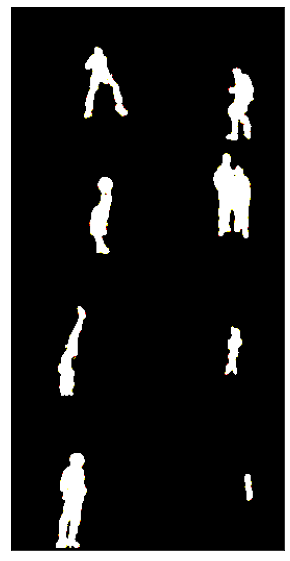

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6569, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0296, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [4000/40000 (20%)]	 Loss: 0.716115
Batch ID: 1000


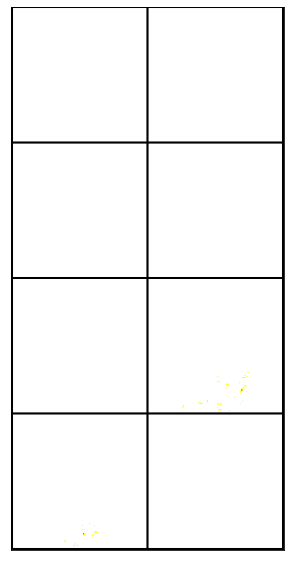

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


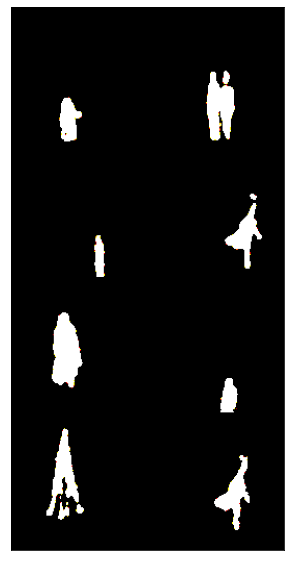

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6287, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0295, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [6000/40000 (30%)]	 Loss: 0.687640
Batch ID: 1500


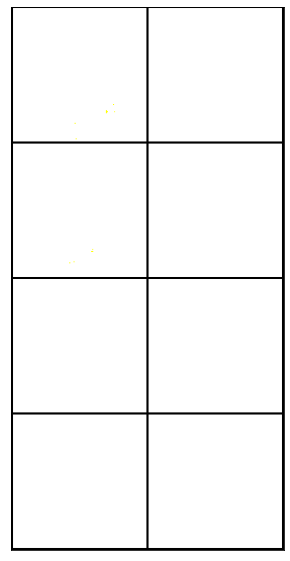

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


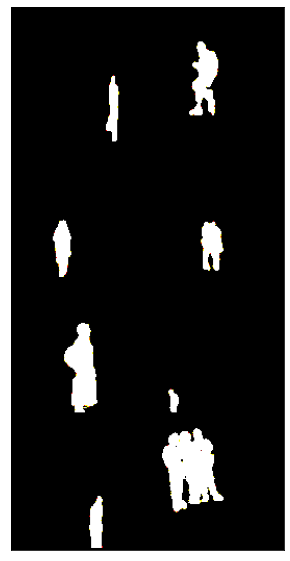

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6170, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0400, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [8000/40000 (40%)]	 Loss: 0.696897
Batch ID: 2000


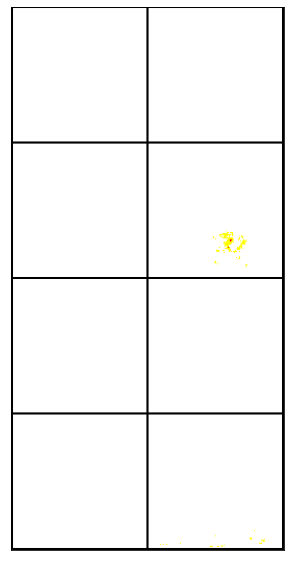

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


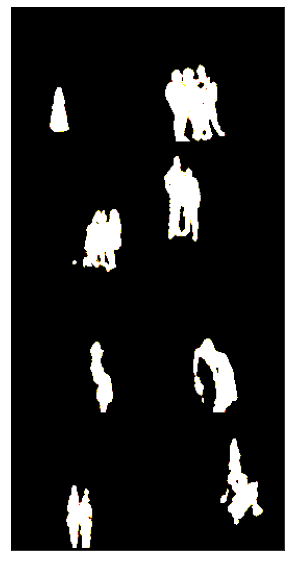

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6483, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0231, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [10000/40000 (50%)]	 Loss: 0.694526
Batch ID: 2500


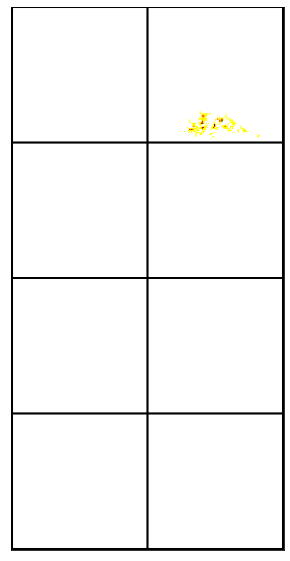

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


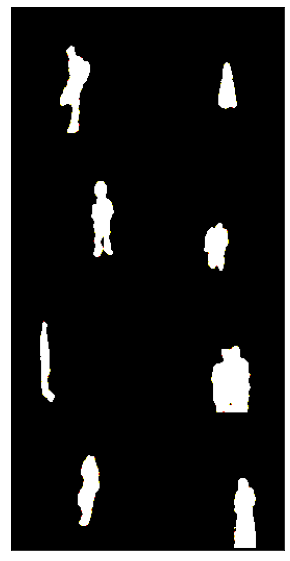

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6189, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0265, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [12000/40000 (60%)]	 Loss: 0.671850
Batch ID: 3000


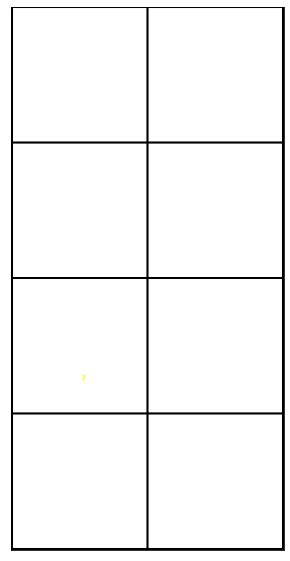

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


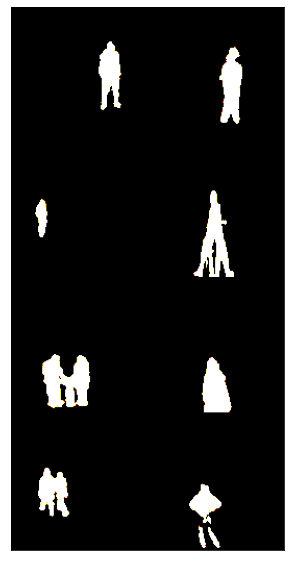

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6250, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0251, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [14000/40000 (70%)]	 Loss: 0.675114
Batch ID: 3500


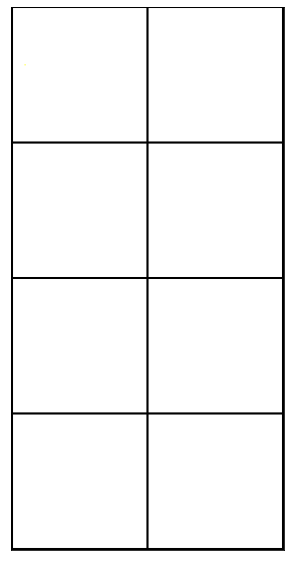

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


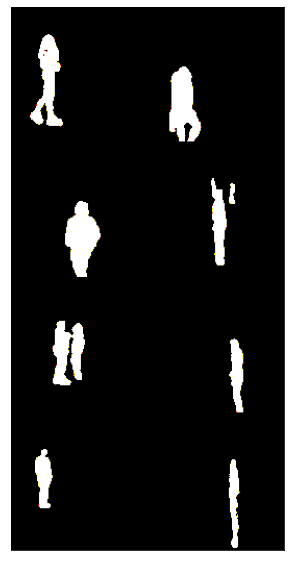

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6205, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0208, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [16000/40000 (80%)]	 Loss: 0.662032
Batch ID: 4000


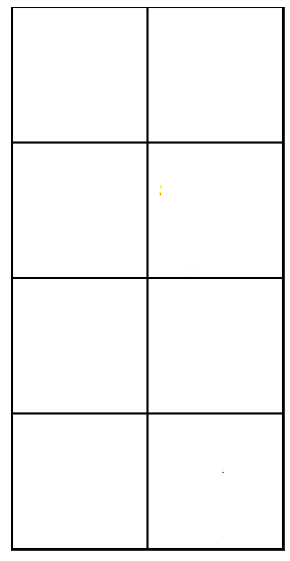

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


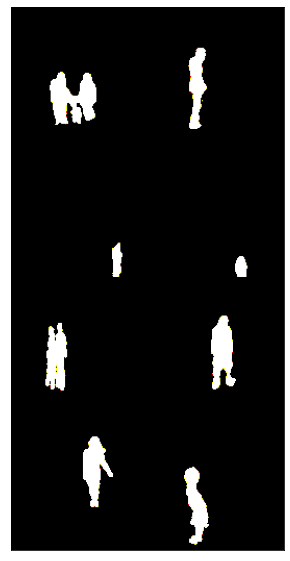

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.6216, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
tensor(0.0316, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Train Epoch: 9 [18000/40000 (90%)]	 Loss: 0.684785
Batch ID: 4500


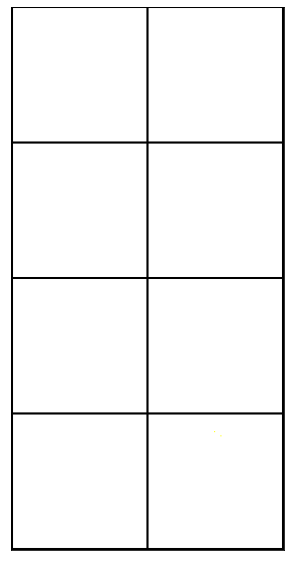

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


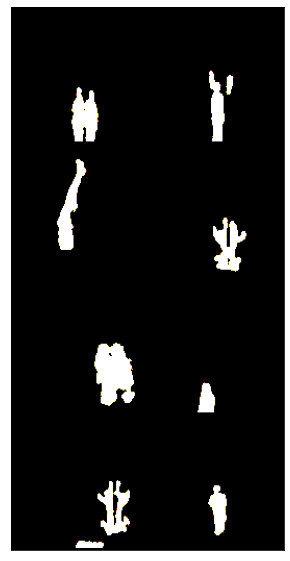

In [21]:
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MSELoss()
scheduler = StepLR(optim, step_size=2, gamma=0.01)
for epoch in range(1, 10):
    train(model, criterion, device, train_loader, optim, epoch)
    scheduler.step()

In [25]:
!pip install torchsummary
from torchsummary import summary
